In [78]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr, mean_squared_error
from skimage.transform import resize

figures_dir = '/u8/d/len/code/strong-lensing-polish-torch/figs/'

In [88]:
class WDSR(nn.Module):
    def __init__(self, num_residual_blocks=32, num_features=32, scale_factor=2):
        super(WDSR, self).__init__()
        self.scale_factor = scale_factor
        
        # Initial convolution
        self.conv_first = nn.Conv2d(1, num_features, kernel_size=3, padding=1)
        
        # Residual blocks
        self.residual_blocks = nn.ModuleList([
            WDSRBlock(num_features) for _ in range(num_residual_blocks)
        ])
        
        # Upsampling
        self.upsample = nn.Sequential(
            nn.Conv2d(num_features, num_features * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )
        
        # Final convolution
        self.conv_last = nn.Conv2d(num_features, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv_first(x)
        residual = x
        for block in self.residual_blocks:
            x = block(x)
        x += residual
        x = self.upsample(x)
        x = self.conv_last(x)
        return x

class WDSRBlock(nn.Module):
    def __init__(self, num_features):
        super(WDSRBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_features, num_features * 4, stride=1, kernel_size=3, padding=1)
        self.act = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_features * 4, num_features, stride=1, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x += residual
        return x

In [92]:
class SuperResolutionDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, start_num, end_num,
                 crop_size=None, transform=None, scale_factor=2):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.transform = transform
        self.image_files = [f"{i:04d}.npy" for i in range(start_num, end_num + 1)]
        self.crop_size = crop_size
        self.scale_factor = scale_factor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        hr_image_path = os.path.join(self.hr_dir, img_name)
        lr_image_path = os.path.join(self.lr_dir, img_name)

        hr_image = np.load(hr_image_path)
        lr_image = np.load(lr_image_path)

        # Print min, max, and shapes of loaded images
#         print(f"Loaded HR image '{img_name}': min={hr_image.min()}, max={hr_image.max()}, shape={hr_image.shape}")
#         print(f"Loaded LR image '{img_name}': min={lr_image.min()}, max={lr_image.max()}, shape={lr_image.shape}")

        hr_image = torch.from_numpy(hr_image).squeeze()
        lr_image = torch.from_numpy(lr_image).squeeze()

        if self.crop_size is not None:
            # Random crop (disabled for inference)
            i, j, h, w = transforms.RandomCrop.get_params(hr_image, output_size=(self.crop_size, self.crop_size))
            hr_image = TF.crop(hr_image, i, j, h, w)
            lr_image = TF.crop(lr_image, i // self.scale_factor, j // self.scale_factor,
                               h // self.scale_factor, w // self.scale_factor)
        else:
            # No cropping, use full images
            pass

        # Convert to numpy array
        hr_image = np.array(hr_image).astype(np.float32)
        lr_image = np.array(lr_image).astype(np.float32)

        # Convert to tensor
        hr_image = torch.from_numpy(hr_image).unsqueeze(0)
        lr_image = torch.from_numpy(lr_image).unsqueeze(0)

        if self.transform:
            hr_image = self.transform(hr_image)
            lr_image = self.transform(lr_image)

        return lr_image, hr_image, img_name

class ResidualLearningDataset(Dataset):
    def __init__(self, hr_dir, residual_dr, lr_dir, start_num, end_num, nbit=0,
                 crop_size=None):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.nbit = nbit
        self.residual_dir = residual_dr
        self.image_files = [f"{i:04d}.npy" for i in range(start_num, end_num + 1)]
        self.crop_size = crop_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        hr_image_path = os.path.join(self.hr_dir, img_name)
        lr_image_path = os.path.join(self.lr_dir, img_name)
        residual_image_path = os.path.join(self.residual_dir, img_name)

        hr_image = np.load(hr_image_path)
        lr_image = np.load(lr_image_path)
        residual_image = np.load(residual_image_path)

        # Print min, max, and shapes of loaded images
#         print(f"Loaded HR image '{img_name}': min={hr_image.min()}, max={hr_image.max()}, shape={hr_image.shape}")
#         print(f"Loaded LR image '{img_name}': min={lr_image.min()}, max={lr_image.max()}, shape={lr_image.shape}")
#         print(f"Loaded residual image '{img_name}': min={residual_image.min()}, max={residual_image.max()}, shape={residual_image.shape}")

        if self.nbit > 0:
            max_value = (2**(self.nbit//2)-1)
            hr_image = hr_image * max_value
            lr_image = lr_image * max_value
            residual_image = residual_image * max_value

        hr_image = torch.from_numpy(hr_image).squeeze()
        lr_image = torch.from_numpy(lr_image).squeeze()
        residual_image = torch.from_numpy(residual_image).squeeze()

        if self.crop_size is not None:
            # Random crop (disabled for inference)
            i, j, h, w = transforms.RandomCrop.get_params(hr_image, output_size=(self.crop_size, self.crop_size))
            hr_image = TF.crop(hr_image, i, j, h, w)
            lr_image = TF.crop(lr_image, i, j, h, w)
            residual_image = TF.crop(residual_image, i, j, h, w)
        else:
            # No cropping, use full images
            pass

        hr_image = np.array(hr_image).astype(np.float32)
        lr_image = np.array(lr_image).astype(np.float32)
        residual_image = np.array(residual_image).astype(np.float32)
        
        # Convert to tensor
        hr_image = torch.from_numpy(hr_image).unsqueeze(0)
        lr_image = torch.from_numpy(lr_image).unsqueeze(0)
        residual_image = torch.from_numpy(residual_image).unsqueeze(0)

        return lr_image, hr_image, residual_image, img_name

In [93]:
strong_model_path = '/u8/d/len/code/strong-lensing-polish-torch/runs/final_data/run3_cropsize512_s2/final_model.pth'
residual_model_path = '/u8/d/len/code/strong-lensing-polish-torch/runs/final_data/run7_residual_IvsI_cropsize512/final_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the strong model
strong_model = WDSR(scale_factor=2).to(device)
strong_model.load_state_dict(torch.load(strong_model_path, map_location=device))
strong_model.eval()

# Load the residual model
residual_model = WDSR(scale_factor=1).to(device)
residual_model.load_state_dict(torch.load(residual_model_path, map_location=device))
residual_model.eval()

/tmp/ipykernel_2248719/1475687538.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  strong_model.load_state_dict(torch.load(strong_model_path, map_location=device))
/tmp/i

WDSR(
  (conv_first): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residual_blocks): ModuleList(
    (0-31): 32 x WDSRBlock(
      (conv1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (upsample): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PixelShuffle(upscale_factor=1)
  )
  (conv_last): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [97]:
data_dir = '/scratch/ondemand28/len/data/DSA_PSF_1024_x2_stronglens'
hr_dir = os.path.join(data_dir, 'POLISH_valid_true')
dirty_dir = os.path.join(data_dir, 'POLISH_valid_dirty')
residual_dir = os.path.join(data_dir, 'POLISH_valid_residual')

# Image indices to load (adjust as needed)
start_num = 800
end_num = 899

# Create datasets
strong_dataset = SuperResolutionDataset(hr_dir, dirty_dir, start_num, end_num, scale_factor=2)
residual_dataset = ResidualLearningDataset(hr_dir, residual_dir, dirty_dir, start_num, end_num, nbit=16)

# Create data loaders
strong_loader = DataLoader(strong_dataset, batch_size=1, shuffle=False)
residual_loader = DataLoader(residual_dataset, batch_size=1, shuffle=False)

Loaded HR image '0800.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0800.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0800.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0800.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0800.npy': min=-0.04465294041787682, max=0.9937636834719575, shape=(1024, 1024, 1)


/tmp/ipykernel_2248719/1979506722.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/1979506722.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/1979506722.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/1979506722.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_

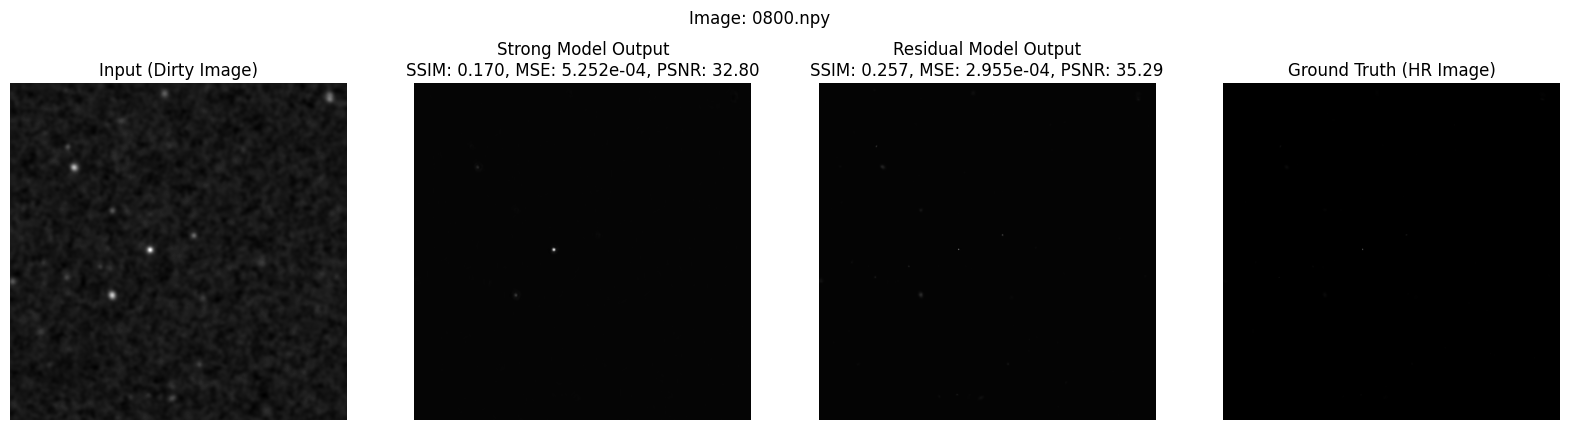

Loaded HR image '0801.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0801.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0801.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0801.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0801.npy': min=-0.6388341356568277, max=0.8852146455609526, shape=(1024, 1024, 1)


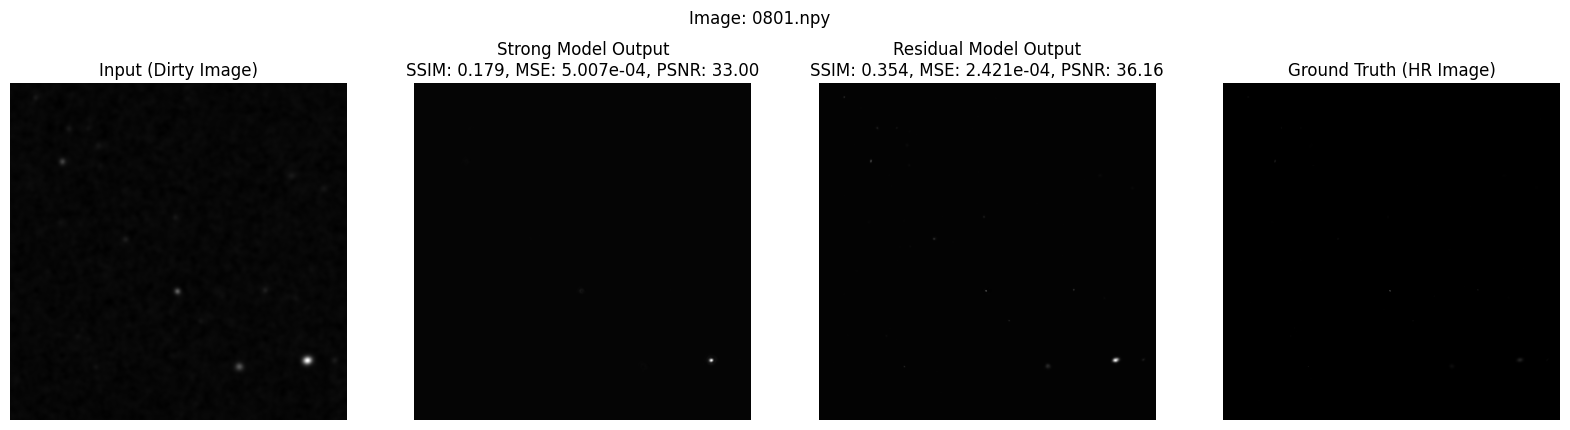

Loaded HR image '0802.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0802.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0802.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0802.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0802.npy': min=-0.2611817935313852, max=0.9350526976760395, shape=(1024, 1024, 1)


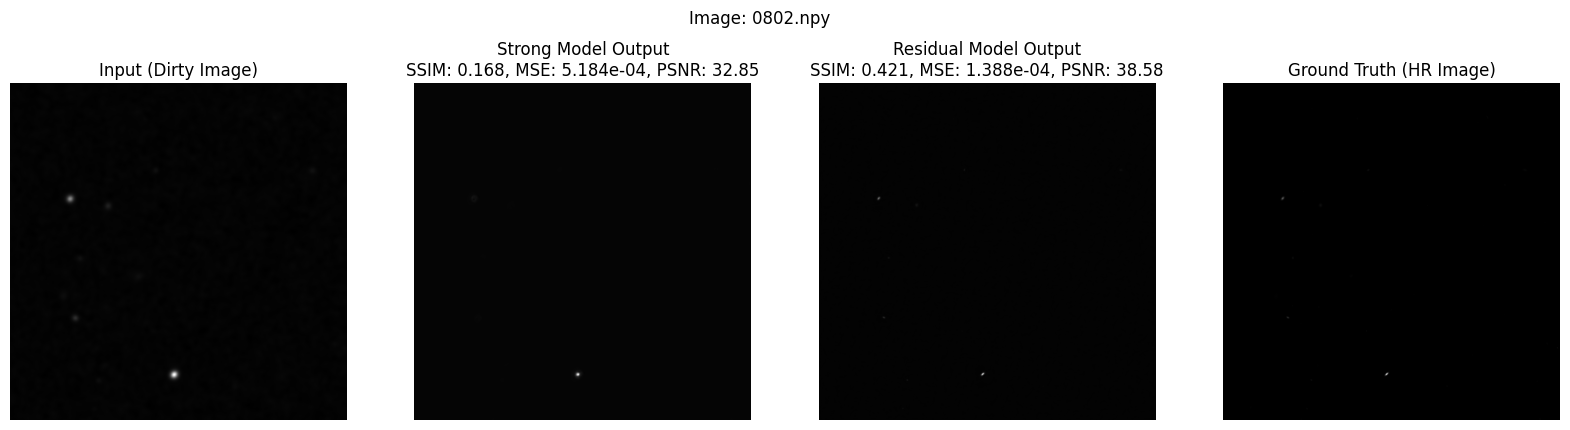

Loaded HR image '0803.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0803.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0803.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0803.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0803.npy': min=-0.7485247909376315, max=0.820884321293591, shape=(1024, 1024, 1)


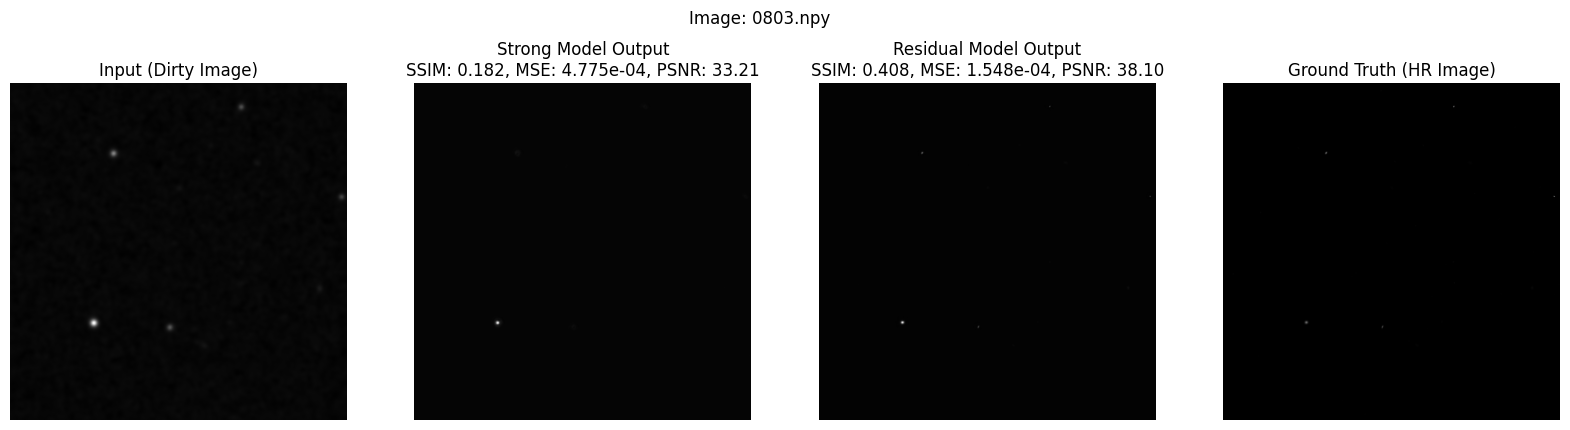

Loaded HR image '0804.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0804.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0804.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0804.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0804.npy': min=-0.2091684673644414, max=0.8776921836261845, shape=(1024, 1024, 1)


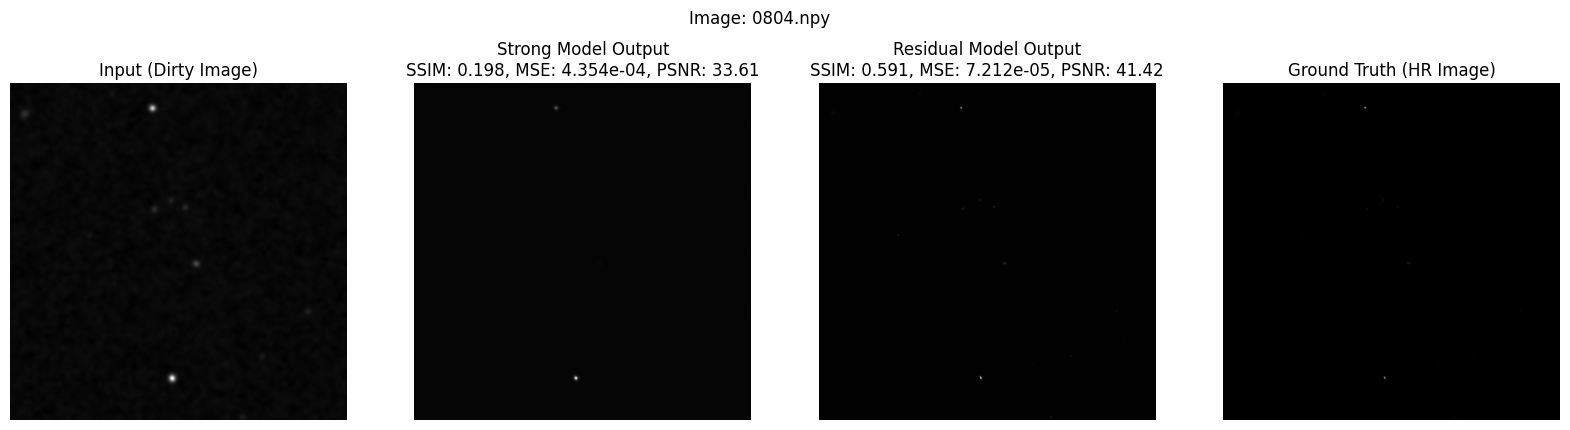

Loaded HR image '0805.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0805.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0805.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0805.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0805.npy': min=-0.14578118008047825, max=0.9274175648061448, shape=(1024, 1024, 1)


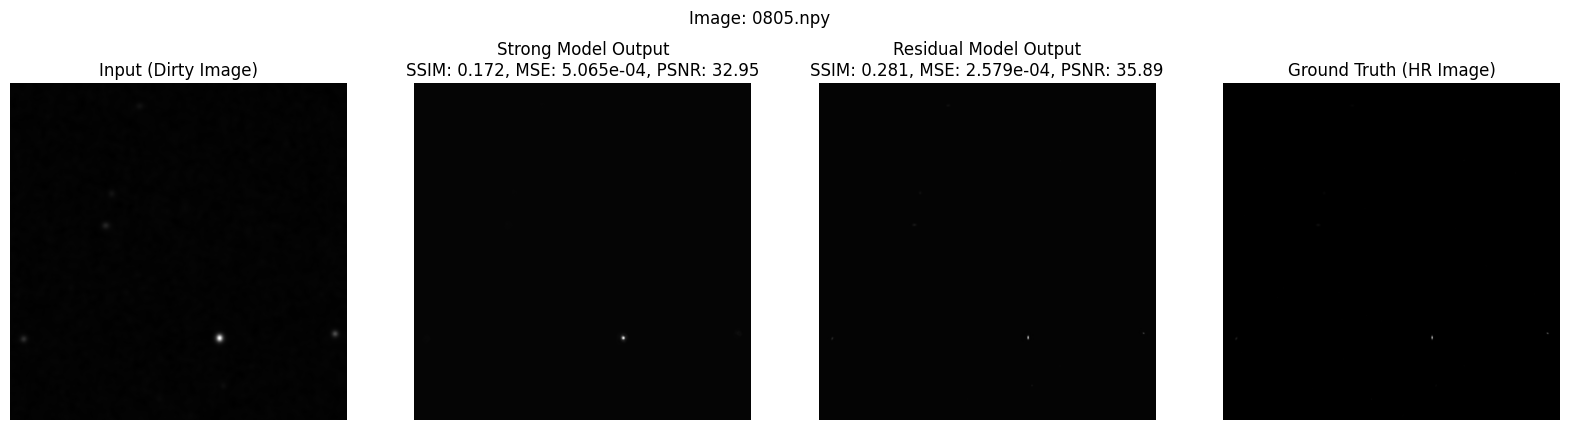

Loaded HR image '0806.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0806.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0806.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0806.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0806.npy': min=-0.044449676889574685, max=0.7251855715467976, shape=(1024, 1024, 1)


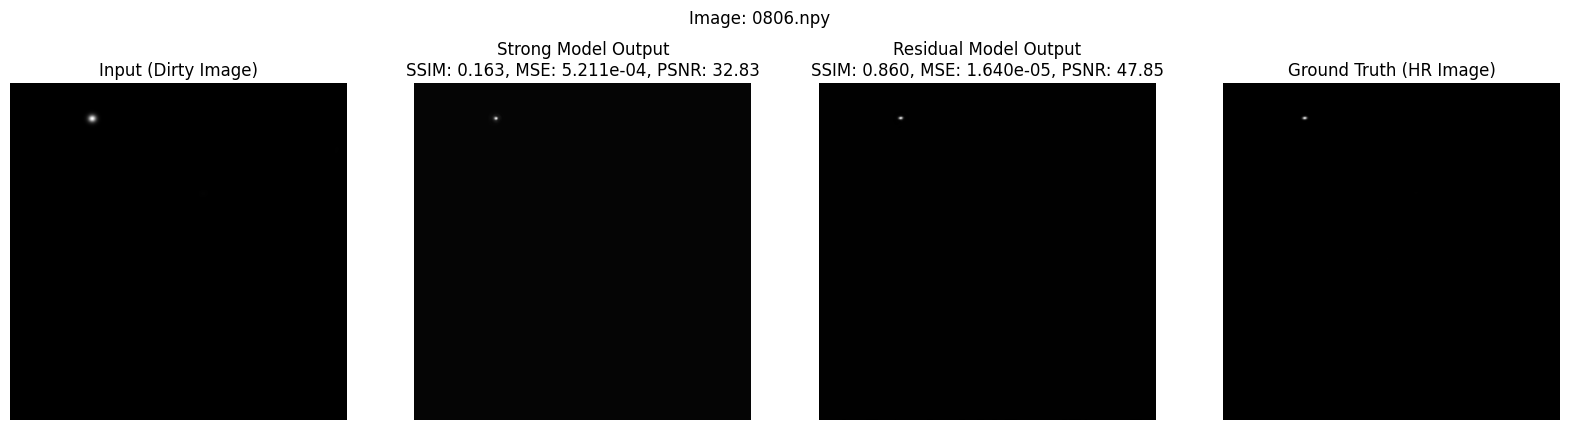

Loaded HR image '0807.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0807.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0807.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0807.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0807.npy': min=-0.048972424856915886, max=0.9980722394064019, shape=(1024, 1024, 1)


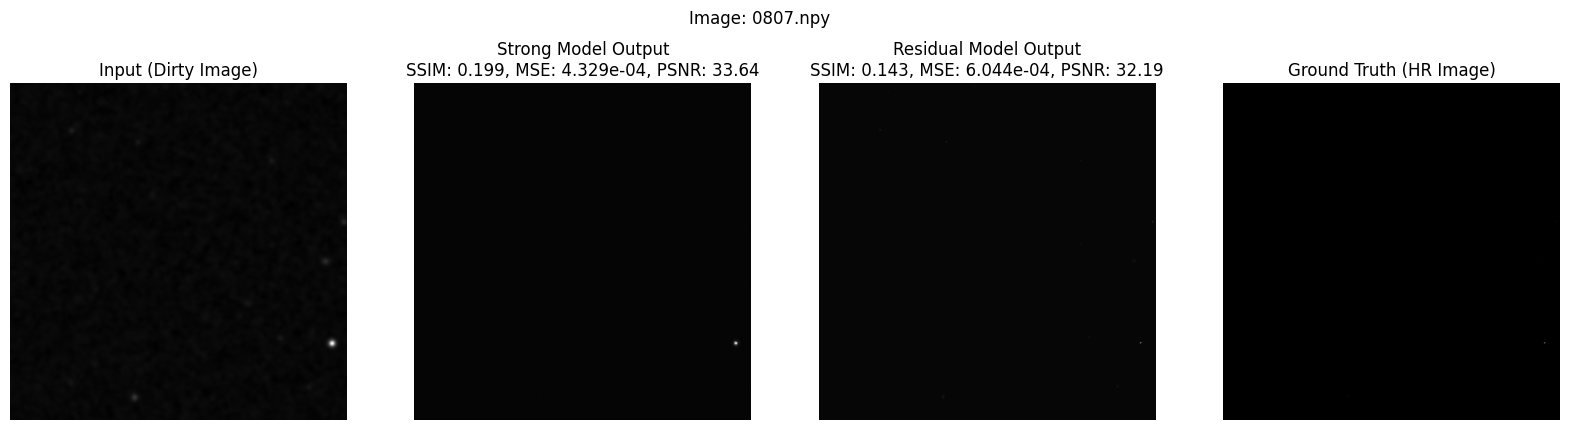

Loaded HR image '0808.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0808.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0808.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0808.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0808.npy': min=-0.3008436380823493, max=0.8702147867050476, shape=(1024, 1024, 1)


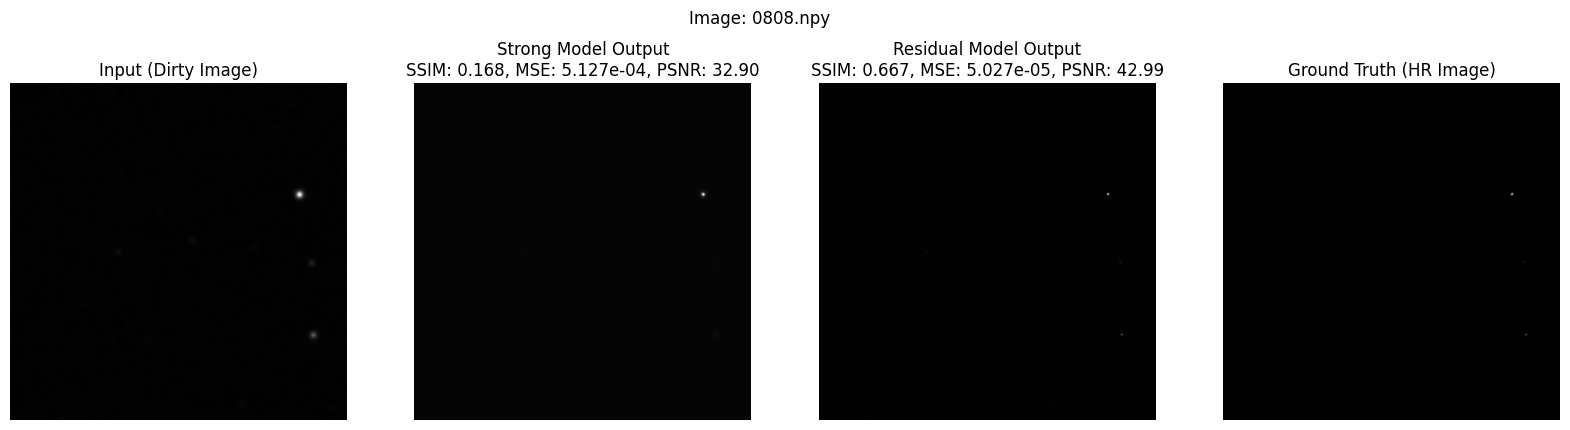

Loaded HR image '0809.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0809.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0809.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0809.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0809.npy': min=-0.6910958213528962, max=0.8752252942851856, shape=(1024, 1024, 1)


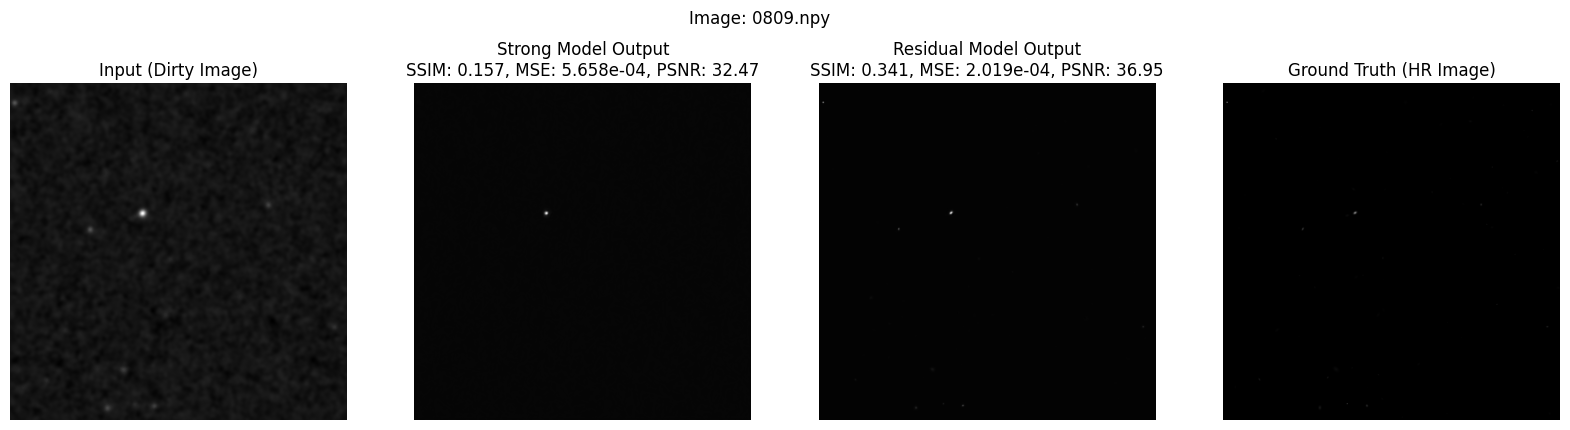

In [24]:
def normalize_image(img):
    img_min = img.min()
    img_max = img.max()
    if img_max > img_min:
        return (img - img_min) / (img_max - img_min)
    else:
        return img - img_min  # Returns zero array if img_max == img_min

# Initialize lists to store results
img_names = []

# Iterate over the datasets
for idx, ((lr_img_strong, hr_img_strong, img_name_strong), (lr_img_residual, hr_img_residual, res_img, img_name_residual)) in enumerate(zip(strong_loader, residual_loader)):
    img_name = img_name_strong
    assert img_name == img_name_residual, "Image names do not match!"

    img_names.append(img_name[0])

    # Move tensors to device
    lr_img_strong = lr_img_strong.to(device)
    hr_img_strong = hr_img_strong.to(device)

    lr_img_residual = lr_img_residual.to(device)
    hr_img_residual = hr_img_residual.to(device)
    res_img = res_img.to(device)

    # Strong model inference
    with torch.no_grad():
        output_strong = strong_model(lr_img_strong)

    # Residual model inference
    with torch.no_grad():
        output_residual = residual_model(lr_img_residual)
        reconstructed_residual = lr_img_residual - output_residual

    # Convert tensors to numpy arrays
    dirty_img_np = lr_img_strong.cpu().numpy()[0, 0, :, :]
    hr_img_np = hr_img_strong.cpu().numpy()[0, 0, :, :]
    output_strong_np = output_strong.cpu().numpy()[0, 0, :, :]
    reconstructed_residual_np = reconstructed_residual.cpu().numpy()[0, 0, :, :]

    # Resize strong model output to match HR image size
    if output_strong_np.shape != hr_img_np.shape:
        output_strong_np = resize(output_strong_np, hr_img_np.shape, mode='reflect', anti_aliasing=True)

    # Normalize images
    hr_img_norm = normalize_image(hr_img_np)
    output_strong_norm = normalize_image(output_strong_np)
    reconstructed_residual_norm = normalize_image(reconstructed_residual_np)
    dirty_img_norm = normalize_image(dirty_img_np)

    # Compute metrics for strong model
    ssim_strong = ssim(hr_img_norm, output_strong_norm, data_range=1.0)
    mse_strong = mean_squared_error(hr_img_norm, output_strong_norm)
    psnr_strong = psnr(hr_img_norm, output_strong_norm, data_range=1.0)

    # Compute metrics for residual model
    ssim_residual = ssim(hr_img_norm, reconstructed_residual_norm, data_range=1.0)
    mse_residual = mean_squared_error(hr_img_norm, reconstructed_residual_norm)
    psnr_residual = psnr(hr_img_norm, reconstructed_residual_norm, data_range=1.0)

    # Plot results
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(dirty_img_np, cmap='gray')
    axs[0].set_title('Input (Dirty Image)')
    axs[0].axis('off')

    axs[1].imshow(output_strong_np, cmap='gray')
    axs[1].set_title(f'Strong Model Output\nSSIM: {ssim_strong:.3f}, MSE: {mse_strong:.3e}, PSNR: {psnr_strong:.2f}')
    axs[1].axis('off')

    axs[2].imshow(reconstructed_residual_np, cmap='gray')
    axs[2].set_title(f'Residual Model Output\nSSIM: {ssim_residual:.3f}, MSE: {mse_residual:.3e}, PSNR: {psnr_residual:.2f}')
    axs[2].axis('off')

    axs[3].imshow(hr_img_np, cmap='gray')
    axs[3].set_title('Ground Truth (HR Image)')
    axs[3].axis('off')

    plt.suptitle(f'Image: {img_name[0]}')
    plt.show()

Loaded HR image '0800.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0800.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded HR image '0800.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded LR image '0800.npy': min=0.0, max=1.0, shape=(1024, 1024, 1)
Loaded residual image '0800.npy': min=-0.04465294041787682, max=0.9937636834719575, shape=(1024, 1024, 1)


/tmp/ipykernel_2248719/1979506722.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/1979506722.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/1979506722.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/1979506722.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_

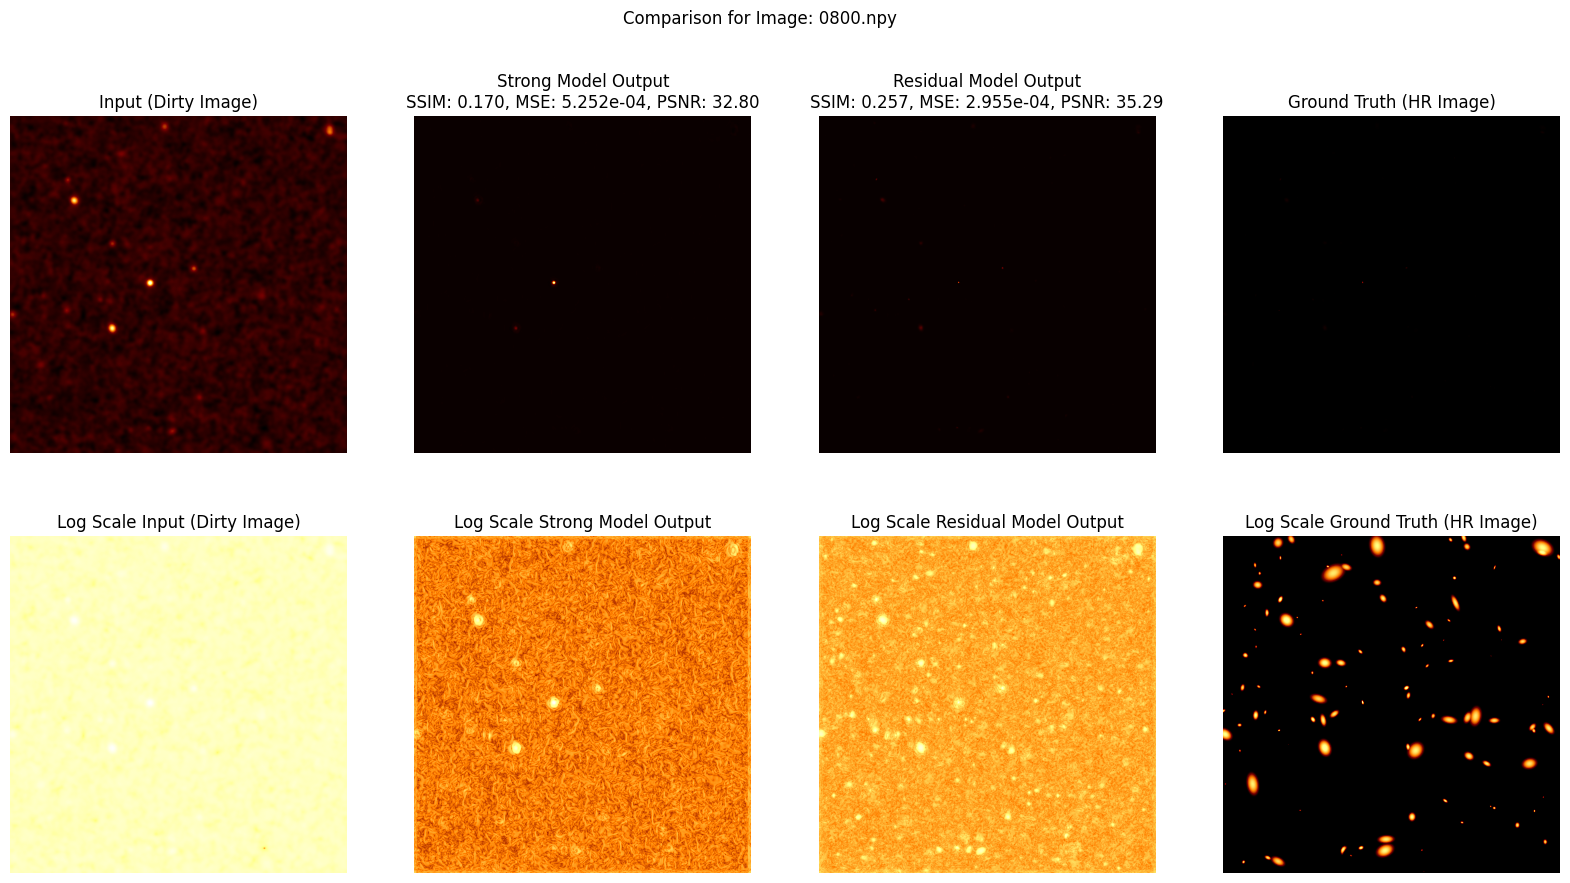

In [31]:
# Cell 7: Compare Results on a Single Image

# Choose an image index to compare (change as needed)
index_to_compare = 0  # Index in the list of loaded images

# Retrieve the tensors
for idx, ((lr_img_strong, hr_img_strong, img_name_strong), (lr_img_residual, hr_img_residual, res_img, img_name_residual)) in enumerate(zip(strong_loader, residual_loader)):
    if idx == index_to_compare:
        img_name = img_name_strong
        assert img_name == img_name_residual, "Image names do not match!"

        # Move tensors to device
        lr_img_strong = lr_img_strong.to(device)
        hr_img_strong = hr_img_strong.to(device)

        lr_img_residual = lr_img_residual.to(device)
        hr_img_residual = hr_img_residual.to(device)
        res_img = res_img.to(device)

        # Strong model inference
        with torch.no_grad():
            output_strong = strong_model(lr_img_strong)

        # Residual model inference
        with torch.no_grad():
            output_residual = residual_model(lr_img_residual)
            reconstructed_residual = lr_img_residual - output_residual

        # Convert tensors to numpy arrays
        dirty_img_np = lr_img_strong.cpu().numpy()[0, 0, :, :]
        hr_img_np = hr_img_strong.cpu().numpy()[0, 0, :, :]
        output_strong_np = output_strong.cpu().numpy()[0, 0, :, :]
        reconstructed_residual_np = reconstructed_residual.cpu().numpy()[0, 0, :, :]

        # Resize strong model output to match HR image size
        if output_strong_np.shape != hr_img_np.shape:
            output_strong_np = resize(output_strong_np, hr_img_np.shape, mode='reflect', anti_aliasing=True)

        # Normalize images
        hr_img_norm = normalize_image(hr_img_np)
        output_strong_norm = normalize_image(output_strong_np)
        reconstructed_residual_norm = normalize_image(reconstructed_residual_np)
        dirty_img_norm = normalize_image(dirty_img_np)

        # Compute metrics for strong model
        ssim_strong = ssim(hr_img_norm, output_strong_norm, data_range=1.0)
        mse_strong = mean_squared_error(hr_img_norm, output_strong_norm)
        psnr_strong = psnr(hr_img_norm, output_strong_norm, data_range=1.0)

        # Compute metrics for residual model
        ssim_residual = ssim(hr_img_norm, reconstructed_residual_norm, data_range=1.0)
        mse_residual = mean_squared_error(hr_img_norm, reconstructed_residual_norm)
        psnr_residual = psnr(hr_img_norm, reconstructed_residual_norm, data_range=1.0)

        # Plot results with detailed comparison
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # First row: Images
        axs[0, 0].imshow(dirty_img_np, cmap='afmhot')
        axs[0, 0].set_title('Input (Dirty Image)')
        axs[0, 0].axis('off')

        axs[0, 1].imshow(output_strong_np, cmap='afmhot')
        axs[0, 1].set_title(f'Strong Model Output\nSSIM: {ssim_strong:.3f}, MSE: {mse_strong:.3e}, PSNR: {psnr_strong:.2f}')
        axs[0, 1].axis('off')

        axs[0, 2].imshow(reconstructed_residual_np, cmap='afmhot')
        axs[0, 2].set_title(f'Residual Model Output\nSSIM: {ssim_residual:.3f}, MSE: {mse_residual:.3e}, PSNR: {psnr_residual:.2f}')
        axs[0, 2].axis('off')

        axs[0, 3].imshow(hr_img_np, cmap='afmhot')
        axs[0, 3].set_title('Ground Truth (HR Image)')
        axs[0, 3].axis('off')

        # Second row: Log-scale Images of the Images Above
        axs[1, 0].imshow(np.log10(np.abs(dirty_img_np) + 1e-8), cmap='afmhot')
        axs[1, 0].set_title('Log Scale Input (Dirty Image)')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(np.log10(np.abs(output_strong_np) + 1e-8), cmap='afmhot')
        axs[1, 1].set_title('Log Scale Strong Model Output')
        axs[1, 1].axis('off')

        axs[1, 2].imshow(np.log10(np.abs(reconstructed_residual_np) + 1e-8), cmap='afmhot')
        axs[1, 2].set_title('Log Scale Residual Model Output')
        axs[1, 2].axis('off')

        axs[1, 3].imshow(np.log10(np.abs(hr_img_np) + 1e-8), cmap='afmhot')
        axs[1, 3].set_title('Log Scale Ground Truth (HR Image)')
        axs[1, 3].axis('off')

        plt.suptitle(f'Comparison for Image: {img_name[0]}')
        plt.show()
        break  # Exit the loop after processing the desired image


/tmp/ipykernel_2248719/2285563961.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_

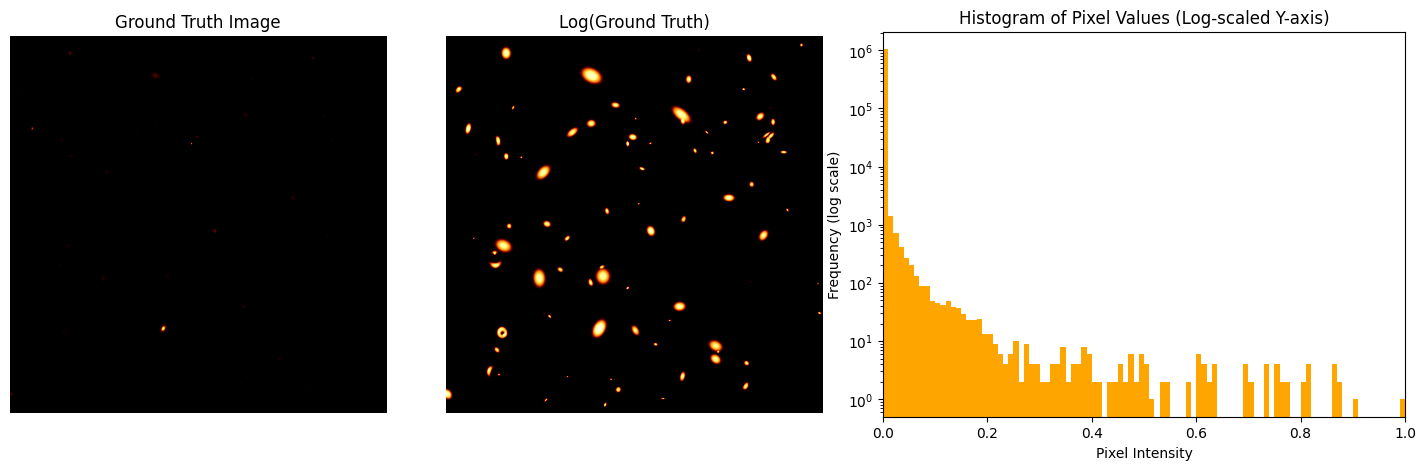

In [95]:
from matplotlib import gridspec

index_to_compare = 15  # Change this to select a different image

for idx, ((_, hr_img_strong, img_name_strong), (_, hr_img_residual, _, img_name_residual)) in enumerate(zip(strong_loader, residual_loader)):
    if idx == index_to_compare:
        img_name = img_name_strong
        assert img_name == img_name_residual, "Image names do not match!"

        # Convert the HR image tensor to a numpy array
        hr_img_np = hr_img_strong.cpu().numpy()[0, 0, :, :]

        # Flatten the image to obtain pixel values
        pixel_values = hr_img_np.flatten()

        # Optionally adjust pixel values to be strictly positive for log scaling
        min_pixel_value = pixel_values.min()
        if min_pixel_value <= 0:
            pixel_values_adjusted = pixel_values - min_pixel_value + 1e-8  # Shift values to be > 0
        else:
            pixel_values_adjusted = pixel_values

        # Compute the log-scale HR image
        hr_img_log = np.log10(np.abs(hr_img_np) + 1e-8)

        # Create a figure with uneven spacing
        fig = plt.figure(figsize=(18, 5))
        spec = gridspec.GridSpec(1, 10, wspace=0.7)  # 5 grid columns for flexibility

        # Display the HR image
        ax1 = fig.add_subplot(spec[0, :3])
        ax1.imshow(hr_img_np, cmap='afmhot')
        ax1.set_title('Ground Truth Image')
        ax1.axis('off')

        # Display the log-scale HR image
        ax2 = fig.add_subplot(spec[0, 3:6])
        ax2.imshow(hr_img_log, cmap='afmhot')
        ax2.set_title('Log(Ground Truth)')
        ax2.axis('off')

        # Extend histogram across 3 columns for extra width
        ax3 = fig.add_subplot(spec[0, 6:])
        ax3.hist(pixel_values_adjusted, bins=100, color='orange', log=True)
        ax3.set_title('Histogram of Pixel Values (Log-scaled Y-axis)')
        ax3.set_xlabel('Pixel Intensity')
        ax3.set_ylabel('Frequency (log scale)')
        ax3.set_xlim(0,1)

#         plt.suptitle(f'HR Image and Pixel Value Histogram for Image: {img_name[0]}')
        plt.tight_layout()
        plt.savefig(f'{figures_dir}pixel_distribution.png', dpi=400)
        plt.show()
        
        break  # Exit the loop after processing the desired image


/tmp/ipykernel_2248719/2285563961.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_

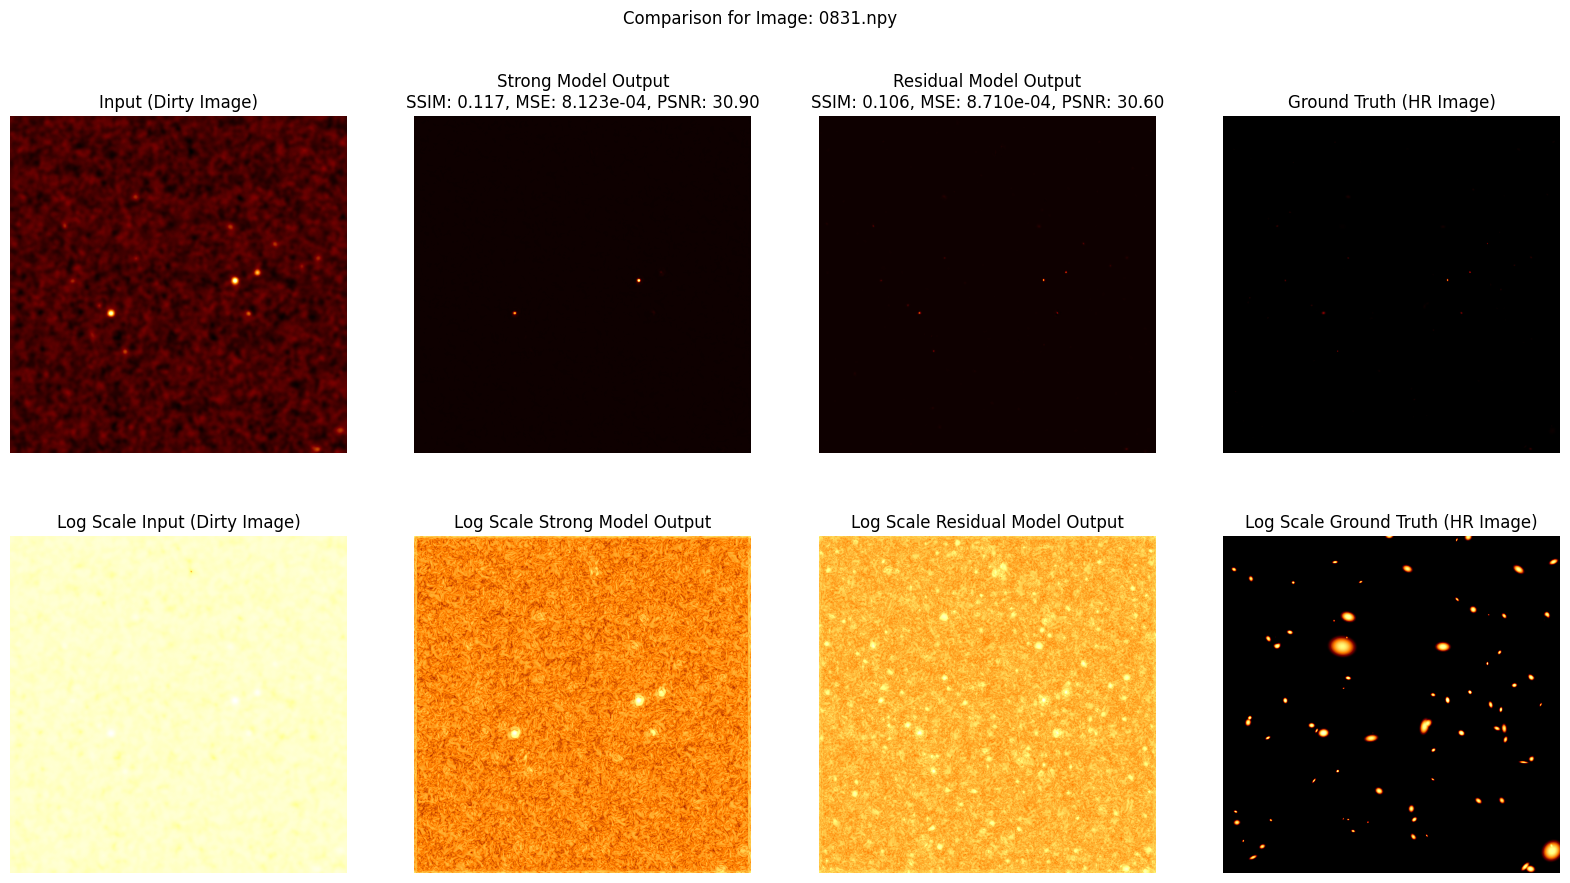

In [103]:
index_to_compare = 31  # Index in the list of loaded images

# Retrieve the tensors
for idx, ((lr_img_strong, hr_img_strong, img_name_strong), (lr_img_residual, hr_img_residual, res_img, img_name_residual)) in enumerate(zip(strong_loader, residual_loader)):
    if idx == index_to_compare:
        img_name = img_name_strong
        assert img_name == img_name_residual, "Image names do not match!"

        # Move tensors to device
        lr_img_strong = lr_img_strong.to(device)
        hr_img_strong = hr_img_strong.to(device)

        lr_img_residual = lr_img_residual.to(device)
        hr_img_residual = hr_img_residual.to(device)
        res_img = res_img.to(device)

        # Strong model inference
        with torch.no_grad():
            output_strong = strong_model(lr_img_strong)

        # Residual model inference
        with torch.no_grad():
            output_residual = residual_model(lr_img_residual)
            reconstructed_residual = lr_img_residual - output_residual

        # Convert tensors to numpy arrays
        dirty_img_np = lr_img_strong.cpu().numpy()[0, 0, :, :]
        hr_img_np = hr_img_strong.cpu().numpy()[0, 0, :, :]
        output_strong_np = output_strong.cpu().numpy()[0, 0, :, :]
        reconstructed_residual_np = reconstructed_residual.cpu().numpy()[0, 0, :, :]

        # Resize strong model output to match HR image size
        if output_strong_np.shape != hr_img_np.shape:
            output_strong_np = resize(output_strong_np, hr_img_np.shape, mode='reflect', anti_aliasing=True)

        # Normalize images
        hr_img_norm = normalize_image(hr_img_np)
        output_strong_norm = normalize_image(output_strong_np)
        reconstructed_residual_norm = normalize_image(reconstructed_residual_np)
        dirty_img_norm = normalize_image(dirty_img_np)

        # Compute metrics for strong model
        ssim_strong = ssim(hr_img_norm, output_strong_norm, data_range=1.0)
        mse_strong = mean_squared_error(hr_img_norm, output_strong_norm)
        psnr_strong = psnr(hr_img_norm, output_strong_norm, data_range=1.0)

        # Compute metrics for residual model
        ssim_residual = ssim(hr_img_norm, reconstructed_residual_norm, data_range=1.0)
        mse_residual = mean_squared_error(hr_img_norm, reconstructed_residual_norm)
        psnr_residual = psnr(hr_img_norm, reconstructed_residual_norm, data_range=1.0)

        # Plot results with detailed comparison
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # First row: Images
        axs[0, 0].imshow(dirty_img_np, cmap='afmhot')
        axs[0, 0].set_title('Input (Dirty Image)')
        axs[0, 0].axis('off')

        axs[0, 1].imshow(output_strong_np, cmap='afmhot')
        axs[0, 1].set_title(f'Strong Model Output\nSSIM: {ssim_strong:.3f}, MSE: {mse_strong:.3e}, PSNR: {psnr_strong:.2f}')
        axs[0, 1].axis('off')

        axs[0, 2].imshow(reconstructed_residual_np, cmap='afmhot')
        axs[0, 2].set_title(f'Residual Model Output\nSSIM: {ssim_residual:.3f}, MSE: {mse_residual:.3e}, PSNR: {psnr_residual:.2f}')
        axs[0, 2].axis('off')

        axs[0, 3].imshow(hr_img_np, cmap='afmhot')
        axs[0, 3].set_title('Ground Truth (HR Image)')
        axs[0, 3].axis('off')

        # Second row: Log-scale Images of the Images Above
        axs[1, 0].imshow(np.log10(np.abs(dirty_img_np) + 1e-8), cmap='afmhot')
        axs[1, 0].set_title('Log Scale Input (Dirty Image)')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(np.log10(np.abs(output_strong_np) + 1e-8), cmap='afmhot')
        axs[1, 1].set_title('Log Scale Strong Model Output')
        axs[1, 1].axis('off')

        axs[1, 2].imshow(np.log10(np.abs(reconstructed_residual_np) + 1e-8), cmap='afmhot')
        axs[1, 2].set_title('Log Scale Residual Model Output')
        axs[1, 2].axis('off')

        axs[1, 3].imshow(np.log10(np.abs(hr_img_np) + 1e-8), cmap='afmhot')
        axs[1, 3].set_title('Log Scale Ground Truth (HR Image)')
        axs[1, 3].axis('off')

        plt.suptitle(f'Comparison for Image: {img_name[0]}')
        plt.show()

/tmp/ipykernel_2248719/2285563961.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_

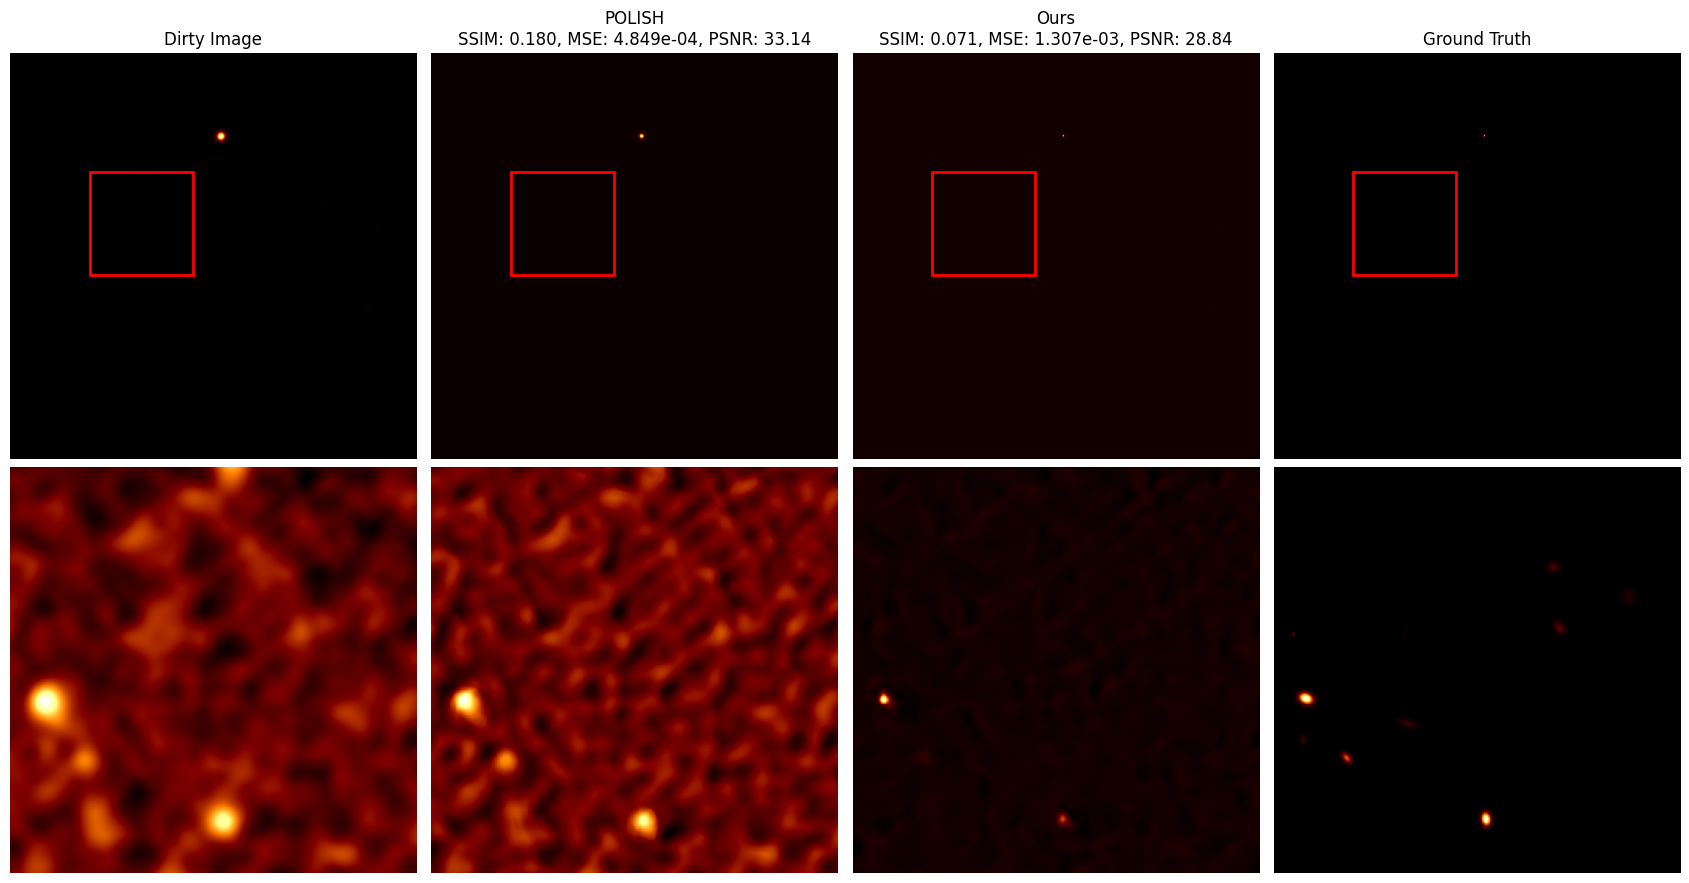

In [163]:
index_to_compare = 12  # Index in the list of loaded images

zoom_start = (300, 200)  # Starting coordinates of the zoom region (row, col)
zoom_size = 260  # Size of the zoom region

# Retrieve the tensors
for idx, ((lr_img_strong, hr_img_strong, img_name_strong), (lr_img_residual, hr_img_residual, res_img, img_name_residual)) in enumerate(zip(strong_loader, residual_loader)):
    if idx == index_to_compare:
        img_name = img_name_strong
        assert img_name == img_name_residual, "Image names do not match!"

        # Move tensors to device
        lr_img_strong = lr_img_strong.to(device)
        hr_img_strong = hr_img_strong.to(device)

        lr_img_residual = lr_img_residual.to(device)
        hr_img_residual = hr_img_residual.to(device)
        res_img = res_img.to(device)

        # Strong model inference
        with torch.no_grad():
            output_strong = strong_model(lr_img_strong)

        # Residual model inference
        with torch.no_grad():
            output_residual = residual_model(lr_img_residual)
            reconstructed_residual = lr_img_residual - output_residual

        # Convert tensors to numpy arrays
        dirty_img_np = lr_img_strong.cpu().numpy()[0, 0, :, :]
        hr_img_np = hr_img_strong.cpu().numpy()[0, 0, :, :]
        output_strong_np = output_strong.cpu().numpy()[0, 0, :, :]
        reconstructed_residual_np = reconstructed_residual.cpu().numpy()[0, 0, :, :]

        # Resize strong model output to match HR image size
        if output_strong_np.shape != hr_img_np.shape:
            output_strong_np = resize(output_strong_np, hr_img_np.shape, mode='reflect', anti_aliasing=True)

        # Normalize images
        hr_img_norm = normalize_image(hr_img_np)
        output_strong_norm = normalize_image(output_strong_np)
        reconstructed_residual_norm = normalize_image(reconstructed_residual_np)
        dirty_img_norm = normalize_image(dirty_img_np)

        # Compute metrics for strong model
        ssim_strong = ssim(hr_img_norm, output_strong_norm, data_range=1.0)
        mse_strong = mean_squared_error(hr_img_norm, output_strong_norm)
        psnr_strong = psnr(hr_img_norm, output_strong_norm, data_range=1.0)

        # Compute metrics for residual model
        ssim_residual = ssim(hr_img_norm, reconstructed_residual_norm, data_range=1.0)
        mse_residual = mean_squared_error(hr_img_norm, reconstructed_residual_norm)
        psnr_residual = psnr(hr_img_norm, reconstructed_residual_norm, data_range=1.0)

        # Define zoom region
        r_start, c_start = zoom_start
        r_end, c_end = r_start + zoom_size, c_start + zoom_size

        # Extract cropped regions
        dirty_img_zoom = dirty_img_np[r_start:r_end, c_start:c_end]
        output_strong_zoom = output_strong_np[r_start:r_end, c_start:c_end]
        reconstructed_residual_zoom = reconstructed_residual_np[r_start:r_end, c_start:c_end]
        hr_img_zoom = hr_img_np[r_start:r_end, c_start:c_end]

        # Plot results with detailed comparison
        fig, axs = plt.subplots(2, 4, figsize=(17, 9))

        # First row: Images with red rectangle
        axs[0, 0].imshow(dirty_img_np, cmap='afmhot')
        axs[0, 0].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 0].set_title('Dirty Image')
        axs[0, 0].axis('off')

        axs[0, 1].imshow(output_strong_np, cmap='afmhot')
        axs[0, 1].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 1].set_title(f'POLISH\nSSIM: {ssim_strong:.3f}, MSE: {mse_strong:.3e}, PSNR: {psnr_strong:.2f}')
        axs[0, 1].axis('off')

        axs[0, 2].imshow(reconstructed_residual_np, cmap='afmhot')
        axs[0, 2].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 2].set_title(f'Ours\nSSIM: {ssim_residual:.3f}, MSE: {mse_residual:.3e}, PSNR: {psnr_residual:.2f}')
        axs[0, 2].axis('off')

        axs[0, 3].imshow(hr_img_np, cmap='afmhot')
        axs[0, 3].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 3].set_title('Ground Truth')
        axs[0, 3].axis('off')

        # Second row: Zoomed regions
        axs[1, 0].imshow(dirty_img_zoom, cmap='afmhot')
#         axs[1, 0].set_title('Zoom Input (Dirty Image)')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(output_strong_zoom, cmap='afmhot')
#         axs[1, 1].set_title('Zoom Strong Model Output')
        axs[1, 1].axis('off')

        axs[1, 2].imshow(reconstructed_residual_zoom, cmap='afmhot')
#         axs[1, 2].set_title('Zoom Residual Model Output')
        axs[1, 2].axis('off')

        axs[1, 3].imshow(hr_img_zoom, cmap='afmhot')
#         axs[1, 3].set_title('Zoom Ground Truth (HR Image)')
        axs[1, 3].axis('off')

#         plt.suptitle(f'Comparison for Image: {img_name[0]} with Zoom-in Region Highlighted')
        plt.tight_layout()
        plt.savefig(f'{figures_dir}cropped_comparison_1.png', dpi=400)
        plt.show()
        break  # Exit the loop after processing the desired image


/tmp/ipykernel_2248719/2285563961.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_

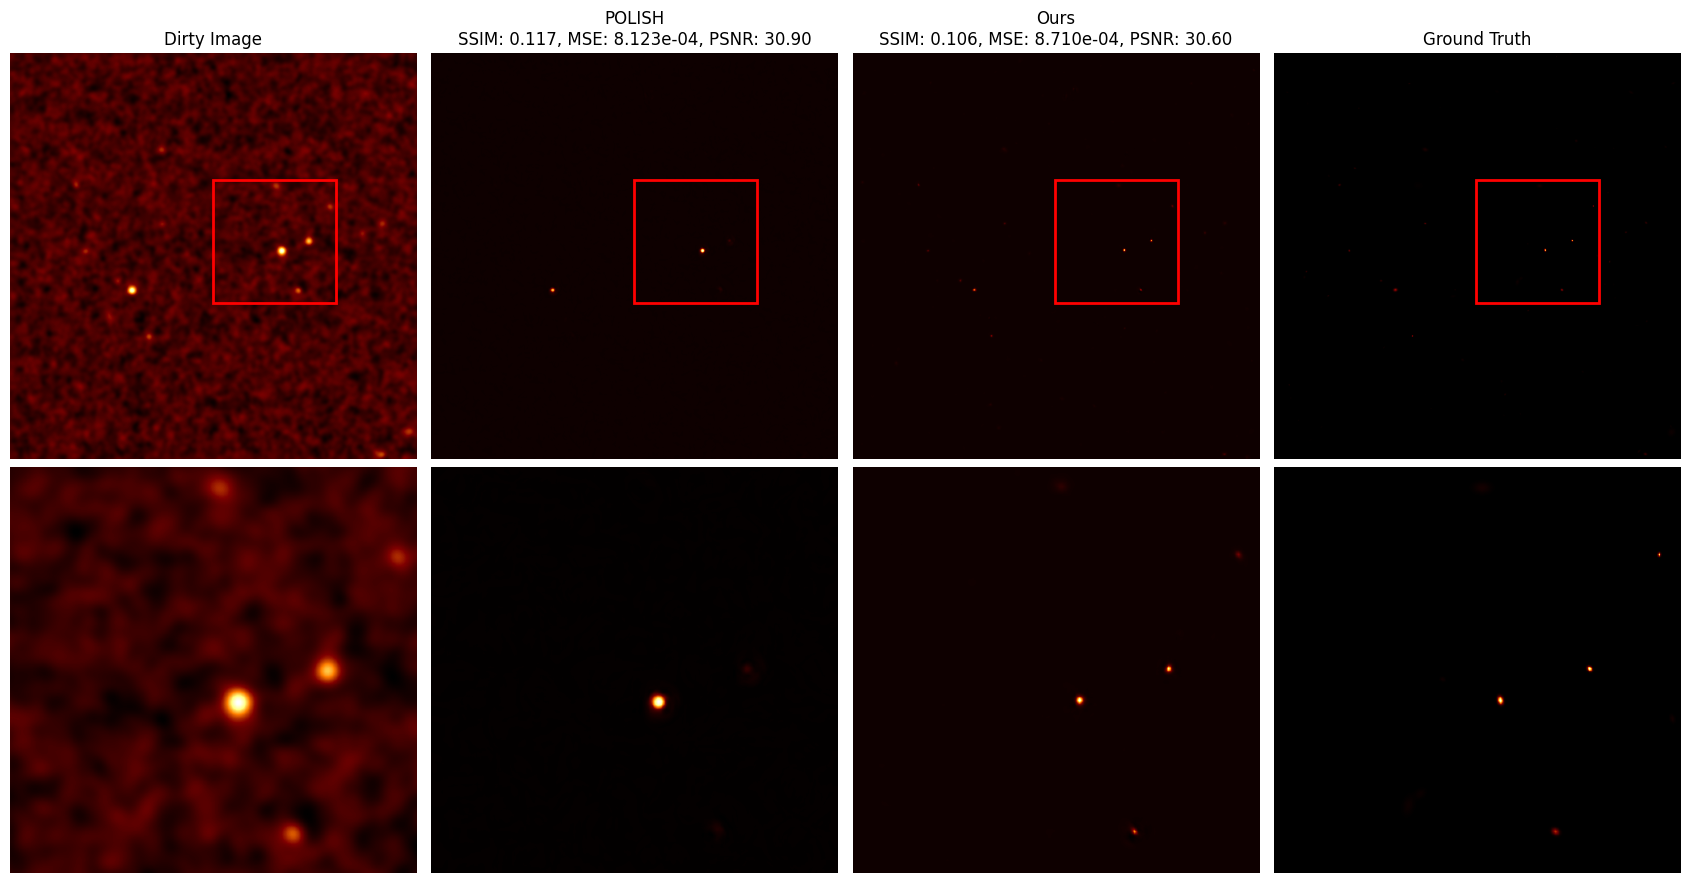

In [162]:
index_to_compare = 31  # Index in the list of loaded images

zoom_start = (320, 510)  # Starting coordinates of the zoom region (row, col)
zoom_size = 310  # Size of the zoom region

# Retrieve the tensors
for idx, ((lr_img_strong, hr_img_strong, img_name_strong), (lr_img_residual, hr_img_residual, res_img, img_name_residual)) in enumerate(zip(strong_loader, residual_loader)):
    if idx == index_to_compare:
        img_name = img_name_strong
        assert img_name == img_name_residual, "Image names do not match!"

        # Move tensors to device
        lr_img_strong = lr_img_strong.to(device)
        hr_img_strong = hr_img_strong.to(device)

        lr_img_residual = lr_img_residual.to(device)
        hr_img_residual = hr_img_residual.to(device)
        res_img = res_img.to(device)

        # Strong model inference
        with torch.no_grad():
            output_strong = strong_model(lr_img_strong)

        # Residual model inference
        with torch.no_grad():
            output_residual = residual_model(lr_img_residual)
            reconstructed_residual = lr_img_residual - output_residual

        # Convert tensors to numpy arrays
        dirty_img_np = lr_img_strong.cpu().numpy()[0, 0, :, :]
        hr_img_np = hr_img_strong.cpu().numpy()[0, 0, :, :]
        output_strong_np = output_strong.cpu().numpy()[0, 0, :, :]
        reconstructed_residual_np = reconstructed_residual.cpu().numpy()[0, 0, :, :]

        # Resize strong model output to match HR image size
        if output_strong_np.shape != hr_img_np.shape:
            output_strong_np = resize(output_strong_np, hr_img_np.shape, mode='reflect', anti_aliasing=True)

        # Normalize images
        hr_img_norm = normalize_image(hr_img_np)
        output_strong_norm = normalize_image(output_strong_np)
        reconstructed_residual_norm = normalize_image(reconstructed_residual_np)
        dirty_img_norm = normalize_image(dirty_img_np)

        # Compute metrics for strong model
        ssim_strong = ssim(hr_img_norm, output_strong_norm, data_range=1.0)
        mse_strong = mean_squared_error(hr_img_norm, output_strong_norm)
        psnr_strong = psnr(hr_img_norm, output_strong_norm, data_range=1.0)

        # Compute metrics for residual model
        ssim_residual = ssim(hr_img_norm, reconstructed_residual_norm, data_range=1.0)
        mse_residual = mean_squared_error(hr_img_norm, reconstructed_residual_norm)
        psnr_residual = psnr(hr_img_norm, reconstructed_residual_norm, data_range=1.0)

        # Define zoom region
        r_start, c_start = zoom_start
        r_end, c_end = r_start + zoom_size, c_start + zoom_size

        # Extract cropped regions
        dirty_img_zoom = dirty_img_np[r_start:r_end, c_start:c_end]
        output_strong_zoom = output_strong_np[r_start:r_end, c_start:c_end]
        reconstructed_residual_zoom = reconstructed_residual_np[r_start:r_end, c_start:c_end]
        hr_img_zoom = hr_img_np[r_start:r_end, c_start:c_end]

        # Plot results with detailed comparison
        fig, axs = plt.subplots(2, 4, figsize=(17, 9))

        # First row: Images with red rectangle
        axs[0, 0].imshow(dirty_img_np, cmap='afmhot')
        axs[0, 0].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 0].set_title('Dirty Image')
        axs[0, 0].axis('off')

        axs[0, 1].imshow(output_strong_np, cmap='afmhot')
        axs[0, 1].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 1].set_title(f'POLISH\nSSIM: {ssim_strong:.3f}, MSE: {mse_strong:.3e}, PSNR: {psnr_strong:.2f}')
        axs[0, 1].axis('off')

        axs[0, 2].imshow(reconstructed_residual_np, cmap='afmhot')
        axs[0, 2].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 2].set_title(f'Ours\nSSIM: {ssim_residual:.3f}, MSE: {mse_residual:.3e}, PSNR: {psnr_residual:.2f}')
        axs[0, 2].axis('off')

        axs[0, 3].imshow(hr_img_np, cmap='afmhot')
        axs[0, 3].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 3].set_title('Ground Truth')
        axs[0, 3].axis('off')

        # Second row: Zoomed regions
        axs[1, 0].imshow(dirty_img_zoom, cmap='afmhot')
#         axs[1, 0].set_title('Zoom Input (Dirty Image)')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(output_strong_zoom, cmap='afmhot')
#         axs[1, 1].set_title('Zoom Strong Model Output')
        axs[1, 1].axis('off')

        axs[1, 2].imshow(reconstructed_residual_zoom, cmap='afmhot')
#         axs[1, 2].set_title('Zoom Residual Model Output')
        axs[1, 2].axis('off')

        axs[1, 3].imshow(hr_img_zoom, cmap='afmhot')
#         axs[1, 3].set_title('Zoom Ground Truth (HR Image)')
        axs[1, 3].axis('off')

#         plt.suptitle(f'Comparison for Image: {img_name[0]} with Zoom-in Region Highlighted')
        plt.tight_layout()
        plt.savefig(f'{figures_dir}cropped_comparison_2.png', dpi=400)
        plt.show()
        break  # Exit the loop after processing the desired image


/tmp/ipykernel_2248719/2285563961.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_

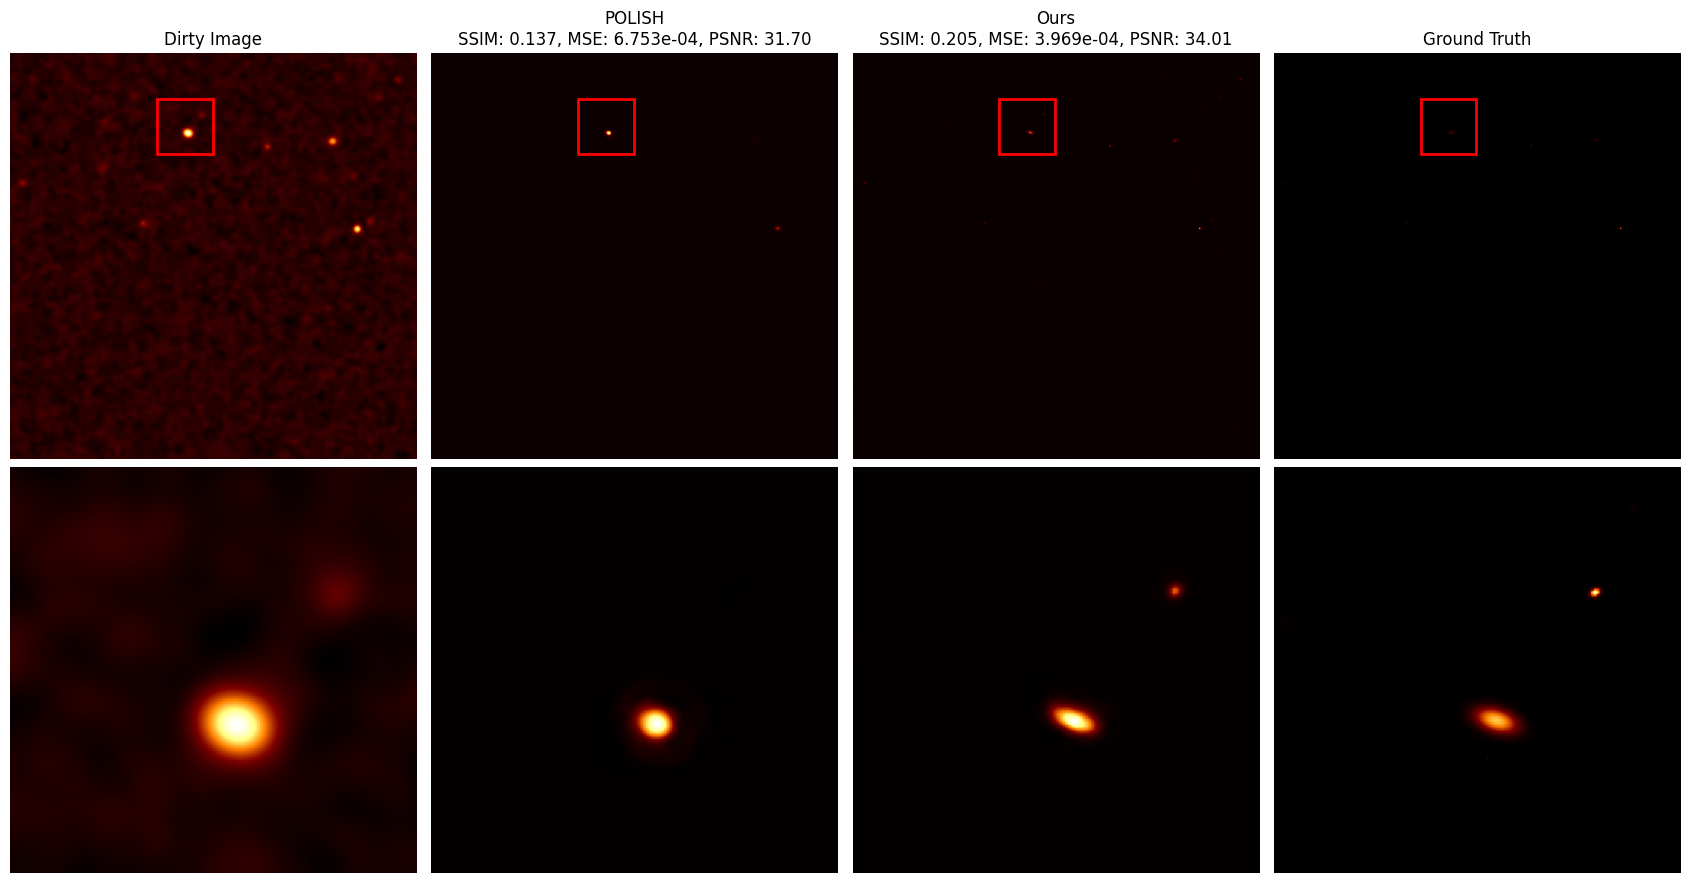

In [185]:
index_to_compare = 28  # Index in the list of loaded images

zoom_start = (115, 370)  # Starting coordinates of the zoom region (row, col)
zoom_size = 140  # Size of the zoom region

# Retrieve the tensors
for idx, ((lr_img_strong, hr_img_strong, img_name_strong), (lr_img_residual, hr_img_residual, res_img, img_name_residual)) in enumerate(zip(strong_loader, residual_loader)):
    if idx == index_to_compare:
        img_name = img_name_strong
        assert img_name == img_name_residual, "Image names do not match!"

        # Move tensors to device
        lr_img_strong = lr_img_strong.to(device)
        hr_img_strong = hr_img_strong.to(device)

        lr_img_residual = lr_img_residual.to(device)
        hr_img_residual = hr_img_residual.to(device)
        res_img = res_img.to(device)

        # Strong model inference
        with torch.no_grad():
            output_strong = strong_model(lr_img_strong)

        # Residual model inference
        with torch.no_grad():
            output_residual = residual_model(lr_img_residual)
            reconstructed_residual = lr_img_residual - output_residual

        # Convert tensors to numpy arrays
        dirty_img_np = lr_img_strong.cpu().numpy()[0, 0, :, :]
        hr_img_np = hr_img_strong.cpu().numpy()[0, 0, :, :]
        output_strong_np = output_strong.cpu().numpy()[0, 0, :, :]
        reconstructed_residual_np = reconstructed_residual.cpu().numpy()[0, 0, :, :]

        # Resize strong model output to match HR image size
        if output_strong_np.shape != hr_img_np.shape:
            output_strong_np = resize(output_strong_np, hr_img_np.shape, mode='reflect', anti_aliasing=True)

        # Normalize images
        hr_img_norm = normalize_image(hr_img_np)
        output_strong_norm = normalize_image(output_strong_np)
        reconstructed_residual_norm = normalize_image(reconstructed_residual_np)
        dirty_img_norm = normalize_image(dirty_img_np)

        # Compute metrics for strong model
        ssim_strong = ssim(hr_img_norm, output_strong_norm, data_range=1.0)
        mse_strong = mean_squared_error(hr_img_norm, output_strong_norm)
        psnr_strong = psnr(hr_img_norm, output_strong_norm, data_range=1.0)

        # Compute metrics for residual model
        ssim_residual = ssim(hr_img_norm, reconstructed_residual_norm, data_range=1.0)
        mse_residual = mean_squared_error(hr_img_norm, reconstructed_residual_norm)
        psnr_residual = psnr(hr_img_norm, reconstructed_residual_norm, data_range=1.0)

        # Define zoom region
        r_start, c_start = zoom_start
        r_end, c_end = r_start + zoom_size, c_start + zoom_size

        # Extract cropped regions
        dirty_img_zoom = dirty_img_np[r_start:r_end, c_start:c_end]
        output_strong_zoom = output_strong_np[r_start:r_end, c_start:c_end]
        reconstructed_residual_zoom = reconstructed_residual_np[r_start:r_end, c_start:c_end]
        hr_img_zoom = hr_img_np[r_start:r_end, c_start:c_end]

        # Plot results with detailed comparison
        fig, axs = plt.subplots(2, 4, figsize=(17, 9))

        # First row: Images with red rectangle
        axs[0, 0].imshow(dirty_img_np, cmap='afmhot')
        axs[0, 0].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 0].set_title('Dirty Image')
        axs[0, 0].axis('off')

        axs[0, 1].imshow(output_strong_np, cmap='afmhot')
        axs[0, 1].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 1].set_title(f'POLISH\nSSIM: {ssim_strong:.3f}, MSE: {mse_strong:.3e}, PSNR: {psnr_strong:.2f}')
        axs[0, 1].axis('off')

        axs[0, 2].imshow(reconstructed_residual_np, cmap='afmhot')
        axs[0, 2].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 2].set_title(f'Ours\nSSIM: {ssim_residual:.3f}, MSE: {mse_residual:.3e}, PSNR: {psnr_residual:.2f}')
        axs[0, 2].axis('off')

        axs[0, 3].imshow(hr_img_np, cmap='afmhot')
        axs[0, 3].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 3].set_title('Ground Truth')
        axs[0, 3].axis('off')

        # Second row: Zoomed regions
        axs[1, 0].imshow(dirty_img_zoom, cmap='afmhot')
#         axs[1, 0].set_title('Zoom Input (Dirty Image)')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(output_strong_zoom, cmap='afmhot')
#         axs[1, 1].set_title('Zoom Strong Model Output')
        axs[1, 1].axis('off')

        axs[1, 2].imshow(reconstructed_residual_zoom, cmap='afmhot')
#         axs[1, 2].set_title('Zoom Residual Model Output')
        axs[1, 2].axis('off')

        axs[1, 3].imshow(hr_img_zoom, cmap='afmhot')
#         axs[1, 3].set_title('Zoom Ground Truth (HR Image)')
        axs[1, 3].axis('off')

#         plt.suptitle(f'Comparison for Image: {img_name[0]} with Zoom-in Region Highlighted')
        plt.tight_layout()
        plt.savefig(f'{figures_dir}cropped_comparison_3.png', dpi=400)
        plt.show()
        break  # Exit the loop after processing the desired image


/tmp/ipykernel_2248719/2285563961.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_

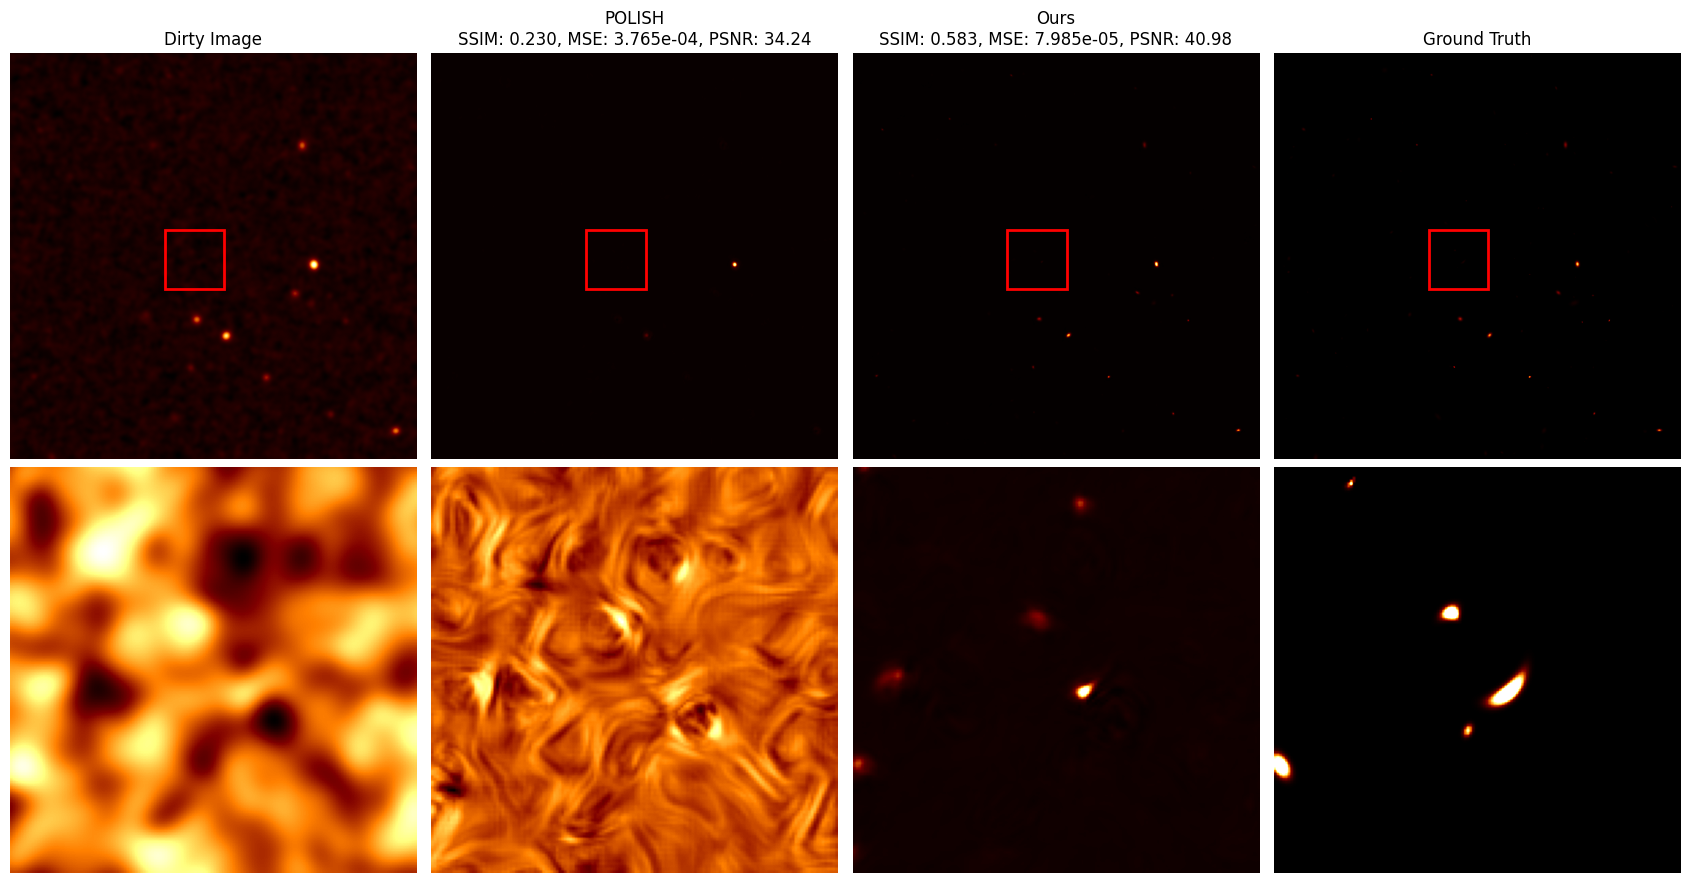

In [189]:
index_to_compare = 33  # Index in the list of loaded images

zoom_start = (445, 390)  # Starting coordinates of the zoom region (row, col)
zoom_size = 150  # Size of the zoom region

# Retrieve the tensors
for idx, ((lr_img_strong, hr_img_strong, img_name_strong), (lr_img_residual, hr_img_residual, res_img, img_name_residual)) in enumerate(zip(strong_loader, residual_loader)):
    if idx == index_to_compare:
        img_name = img_name_strong
        assert img_name == img_name_residual, "Image names do not match!"

        # Move tensors to device
        lr_img_strong = lr_img_strong.to(device)
        hr_img_strong = hr_img_strong.to(device)

        lr_img_residual = lr_img_residual.to(device)
        hr_img_residual = hr_img_residual.to(device)
        res_img = res_img.to(device)

        # Strong model inference
        with torch.no_grad():
            output_strong = strong_model(lr_img_strong)

        # Residual model inference
        with torch.no_grad():
            output_residual = residual_model(lr_img_residual)
            reconstructed_residual = lr_img_residual - output_residual

        # Convert tensors to numpy arrays
        dirty_img_np = lr_img_strong.cpu().numpy()[0, 0, :, :]
        hr_img_np = hr_img_strong.cpu().numpy()[0, 0, :, :]
        output_strong_np = output_strong.cpu().numpy()[0, 0, :, :]
        reconstructed_residual_np = reconstructed_residual.cpu().numpy()[0, 0, :, :]

        # Resize strong model output to match HR image size
        if output_strong_np.shape != hr_img_np.shape:
            output_strong_np = resize(output_strong_np, hr_img_np.shape, mode='reflect', anti_aliasing=True)

        # Normalize images
        hr_img_norm = normalize_image(hr_img_np)
        output_strong_norm = normalize_image(output_strong_np)
        reconstructed_residual_norm = normalize_image(reconstructed_residual_np)
        dirty_img_norm = normalize_image(dirty_img_np)

        # Compute metrics for strong model
        ssim_strong = ssim(hr_img_norm, output_strong_norm, data_range=1.0)
        mse_strong = mean_squared_error(hr_img_norm, output_strong_norm)
        psnr_strong = psnr(hr_img_norm, output_strong_norm, data_range=1.0)

        # Compute metrics for residual model
        ssim_residual = ssim(hr_img_norm, reconstructed_residual_norm, data_range=1.0)
        mse_residual = mean_squared_error(hr_img_norm, reconstructed_residual_norm)
        psnr_residual = psnr(hr_img_norm, reconstructed_residual_norm, data_range=1.0)

        # Define zoom region
        r_start, c_start = zoom_start
        r_end, c_end = r_start + zoom_size, c_start + zoom_size

        # Extract cropped regions
        dirty_img_zoom = dirty_img_np[r_start:r_end, c_start:c_end]
        output_strong_zoom = output_strong_np[r_start:r_end, c_start:c_end]
        reconstructed_residual_zoom = reconstructed_residual_np[r_start:r_end, c_start:c_end]
        hr_img_zoom = hr_img_np[r_start:r_end, c_start:c_end]

        # Plot results with detailed comparison
        fig, axs = plt.subplots(2, 4, figsize=(17, 9))

        # First row: Images with red rectangle
        axs[0, 0].imshow(dirty_img_np, cmap='afmhot')
        axs[0, 0].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 0].set_title('Dirty Image')
        axs[0, 0].axis('off')

        axs[0, 1].imshow(output_strong_np, cmap='afmhot')
        axs[0, 1].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 1].set_title(f'POLISH\nSSIM: {ssim_strong:.3f}, MSE: {mse_strong:.3e}, PSNR: {psnr_strong:.2f}')
        axs[0, 1].axis('off')

        axs[0, 2].imshow(reconstructed_residual_np, cmap='afmhot')
        axs[0, 2].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 2].set_title(f'Ours\nSSIM: {ssim_residual:.3f}, MSE: {mse_residual:.3e}, PSNR: {psnr_residual:.2f}')
        axs[0, 2].axis('off')

        axs[0, 3].imshow(hr_img_np, cmap='afmhot')
        axs[0, 3].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 3].set_title('Ground Truth')
        axs[0, 3].axis('off')

        # Second row: Zoomed regions
        axs[1, 0].imshow(dirty_img_zoom, cmap='afmhot')
#         axs[1, 0].set_title('Zoom Input (Dirty Image)')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(output_strong_zoom, cmap='afmhot')
#         axs[1, 1].set_title('Zoom Strong Model Output')
        axs[1, 1].axis('off')

        axs[1, 2].imshow(reconstructed_residual_zoom, cmap='afmhot', vmax=0.7 * reconstructed_residual_zoom.max())
#         axs[1, 2].set_title('Zoom Residual Model Output')
        axs[1, 2].axis('off')

        axs[1, 3].imshow(hr_img_zoom, cmap='afmhot', vmax=0.02)
#         axs[1, 3].set_title('Zoom Ground Truth (HR Image)')
        axs[1, 3].axis('off')

#         plt.suptitle(f'Comparison for Image: {img_name[0]} with Zoom-in Region Highlighted')
        plt.tight_layout()
        plt.savefig(f'{figures_dir}cropped_comparison_4.png', dpi=400)
        plt.show()
        break  # Exit the loop after processing the desired image


/tmp/ipykernel_2248719/2285563961.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_

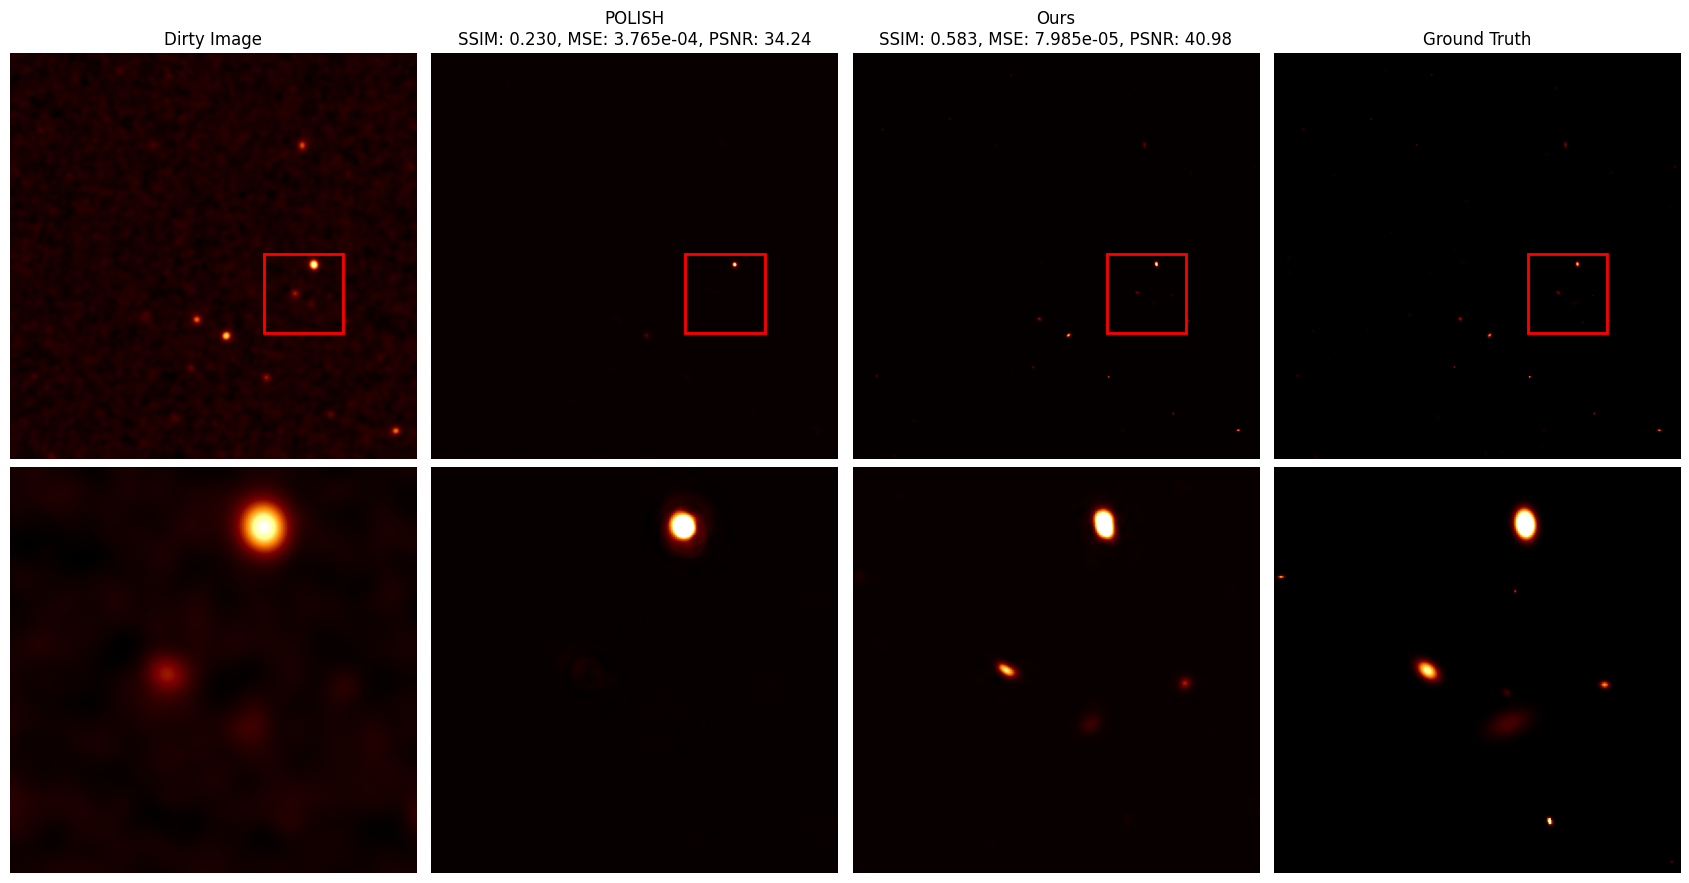

In [196]:
index_to_compare = 33  # Index in the list of loaded images

zoom_start = (505, 640)  # Starting coordinates of the zoom region (row, col)
zoom_size = 200  # Size of the zoom region

# Retrieve the tensors
for idx, ((lr_img_strong, hr_img_strong, img_name_strong), (lr_img_residual, hr_img_residual, res_img, img_name_residual)) in enumerate(zip(strong_loader, residual_loader)):
    if idx == index_to_compare:
        img_name = img_name_strong
        assert img_name == img_name_residual, "Image names do not match!"

        # Move tensors to device
        lr_img_strong = lr_img_strong.to(device)
        hr_img_strong = hr_img_strong.to(device)

        lr_img_residual = lr_img_residual.to(device)
        hr_img_residual = hr_img_residual.to(device)
        res_img = res_img.to(device)

        # Strong model inference
        with torch.no_grad():
            output_strong = strong_model(lr_img_strong)

        # Residual model inference
        with torch.no_grad():
            output_residual = residual_model(lr_img_residual)
            reconstructed_residual = lr_img_residual - output_residual

        # Convert tensors to numpy arrays
        dirty_img_np = lr_img_strong.cpu().numpy()[0, 0, :, :]
        hr_img_np = hr_img_strong.cpu().numpy()[0, 0, :, :]
        output_strong_np = output_strong.cpu().numpy()[0, 0, :, :]
        reconstructed_residual_np = reconstructed_residual.cpu().numpy()[0, 0, :, :]

        # Resize strong model output to match HR image size
        if output_strong_np.shape != hr_img_np.shape:
            output_strong_np = resize(output_strong_np, hr_img_np.shape, mode='reflect', anti_aliasing=True)

        # Normalize images
        hr_img_norm = normalize_image(hr_img_np)
        output_strong_norm = normalize_image(output_strong_np)
        reconstructed_residual_norm = normalize_image(reconstructed_residual_np)
        dirty_img_norm = normalize_image(dirty_img_np)

        # Compute metrics for strong model
        ssim_strong = ssim(hr_img_norm, output_strong_norm, data_range=1.0)
        mse_strong = mean_squared_error(hr_img_norm, output_strong_norm)
        psnr_strong = psnr(hr_img_norm, output_strong_norm, data_range=1.0)

        # Compute metrics for residual model
        ssim_residual = ssim(hr_img_norm, reconstructed_residual_norm, data_range=1.0)
        mse_residual = mean_squared_error(hr_img_norm, reconstructed_residual_norm)
        psnr_residual = psnr(hr_img_norm, reconstructed_residual_norm, data_range=1.0)

        # Define zoom region
        r_start, c_start = zoom_start
        r_end, c_end = r_start + zoom_size, c_start + zoom_size

        # Extract cropped regions
        dirty_img_zoom = dirty_img_np[r_start:r_end, c_start:c_end]
        output_strong_zoom = output_strong_np[r_start:r_end, c_start:c_end]
        reconstructed_residual_zoom = reconstructed_residual_np[r_start:r_end, c_start:c_end]
        hr_img_zoom = hr_img_np[r_start:r_end, c_start:c_end]

        # Plot results with detailed comparison
        fig, axs = plt.subplots(2, 4, figsize=(17, 9))

        # First row: Images with red rectangle
        axs[0, 0].imshow(dirty_img_np, cmap='afmhot')
        axs[0, 0].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 0].set_title('Dirty Image')
        axs[0, 0].axis('off')

        axs[0, 1].imshow(output_strong_np, cmap='afmhot')
        axs[0, 1].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 1].set_title(f'POLISH\nSSIM: {ssim_strong:.3f}, MSE: {mse_strong:.3e}, PSNR: {psnr_strong:.2f}')
        axs[0, 1].axis('off')

        axs[0, 2].imshow(reconstructed_residual_np, cmap='afmhot')
        axs[0, 2].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 2].set_title(f'Ours\nSSIM: {ssim_residual:.3f}, MSE: {mse_residual:.3e}, PSNR: {psnr_residual:.2f}')
        axs[0, 2].axis('off')

        axs[0, 3].imshow(hr_img_np, cmap='afmhot')
        axs[0, 3].add_patch(plt.Rectangle((c_start, r_start), zoom_size, zoom_size, edgecolor='red', facecolor='none', lw=2))
        axs[0, 3].set_title('Ground Truth')
        axs[0, 3].axis('off')

        # Second row: Zoomed regions
        axs[1, 0].imshow(dirty_img_zoom, cmap='afmhot')
#         axs[1, 0].set_title('Zoom Input (Dirty Image)')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(output_strong_zoom, cmap='afmhot', vmax = 0.4 * output_strong_zoom.max())
#         axs[1, 1].set_title('Zoom Strong Model Output')
        axs[1, 1].axis('off')

        axs[1, 2].imshow(reconstructed_residual_zoom, cmap='afmhot', vmax=0.4 * reconstructed_residual_zoom.max())
#         axs[1, 2].set_title('Zoom Residual Model Output')
        axs[1, 2].axis('off')

        axs[1, 3].imshow(hr_img_zoom, cmap='afmhot', vmax=0.4 * hr_img_zoom.max())
#         axs[1, 3].set_title('Zoom Ground Truth (HR Image)')
        axs[1, 3].axis('off')

#         plt.suptitle(f'Comparison for Image: {img_name[0]} with Zoom-in Region Highlighted')
        plt.tight_layout()
        plt.savefig(f'{figures_dir}cropped_comparison_5.png', dpi=400)
        plt.show()
        break  # Exit the loop after processing the desired image


/tmp/ipykernel_2248719/2285563961.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:103: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  residual_image = np.array(residual_image).astype(np.float32)


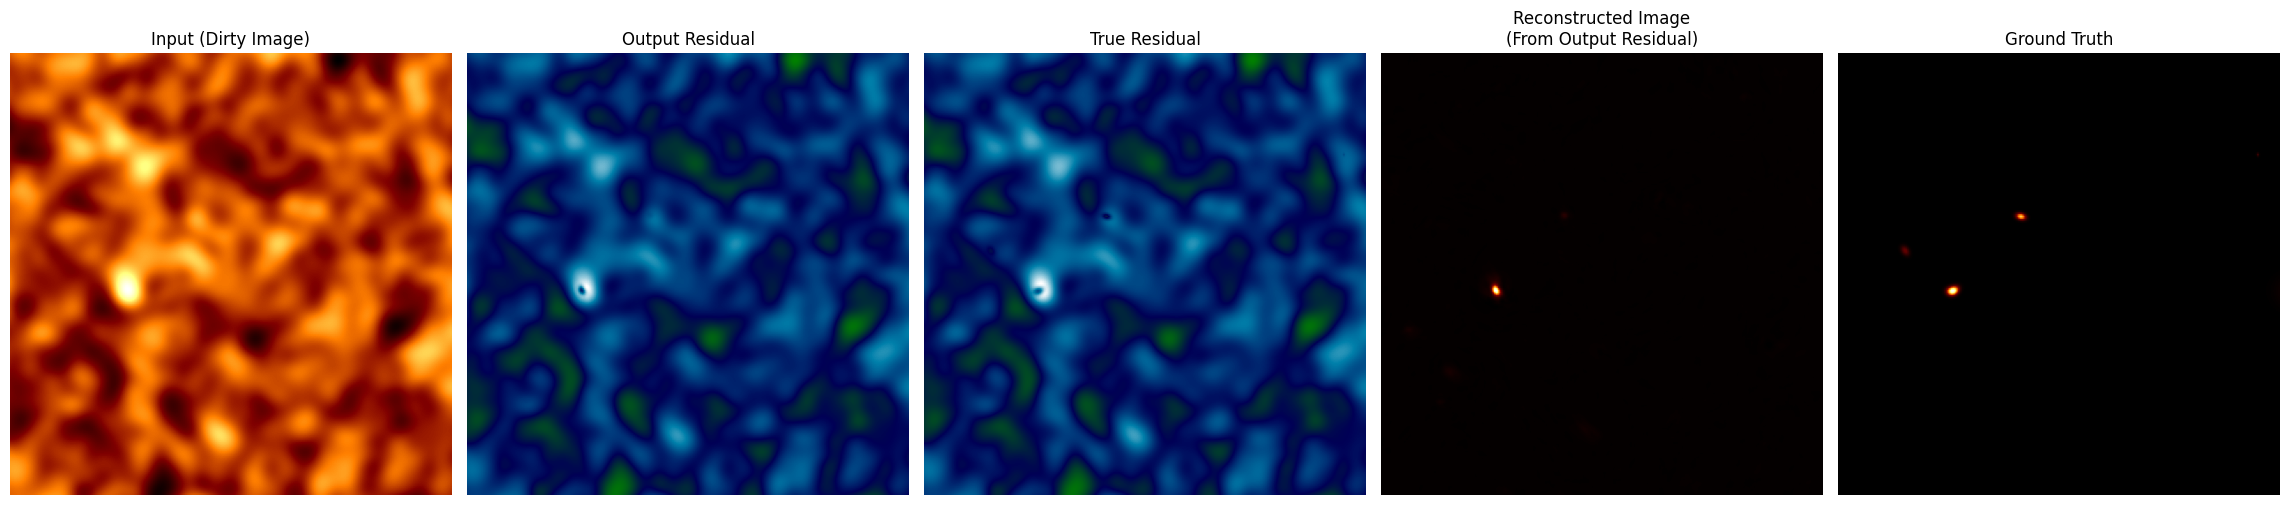

In [209]:
index_to_compare = 31  # Index in the list of loaded images
crop_coords = (200, 100, 450, 350)  # Coordinates for cropping (y_min, x_min, y_max, x_max)

# Retrieve the tensors
for idx, data in enumerate(residual_loader):
    # Unpack the batch data properly
    lr_img_residual, hr_img_residual, res_img, img_name_residual = data

    if idx == index_to_compare:
        img_name = img_name_residual[0]  # Use the first (and only) batch image name

        # Move tensors to device
        lr_img_residual = lr_img_residual.to(device)
        hr_img_residual = hr_img_residual.to(device)
        res_img = res_img.to(device)

        # Residual model inference
        with torch.no_grad():
            output_residual = residual_model(lr_img_residual)
            reconstructed_residual = lr_img_residual - output_residual

        # Convert tensors to numpy arrays
        dirty_img_np = lr_img_residual.cpu().numpy()[0, 0, :, :]
        hr_img_np = hr_img_residual.cpu().numpy()[0, 0, :, :]
        output_residual_np = output_residual.cpu().numpy()[0, 0, :, :]
        reconstructed_residual_np = reconstructed_residual.cpu().numpy()[0, 0, :, :]
        true_residual_np = res_img.cpu().numpy()[0, 0, :, :]

        # Crop the region of interest
        y_min, x_min, y_max, x_max = crop_coords
        dirty_img_crop = dirty_img_np[y_min:y_max, x_min:x_max]
        hr_img_crop = hr_img_np[y_min:y_max, x_min:x_max]
        output_residual_crop = output_residual_np[y_min:y_max, x_min:x_max]
        reconstructed_residual_crop = reconstructed_residual_np[y_min:y_max, x_min:x_max]
        true_residual_crop = true_residual_np[y_min:y_max, x_min:x_max]

        # Normalize cropped images
        dirty_img_crop_norm = normalize_image(dirty_img_crop)
        hr_img_crop_norm = normalize_image(hr_img_crop)
        output_residual_crop_norm = normalize_image(output_residual_crop)
        reconstructed_residual_crop_norm = normalize_image(reconstructed_residual_crop)
        true_residual_crop_norm = normalize_image(true_residual_crop)

        # Plot results focusing on the cropped region
        fig, axs = plt.subplots(1, 5, figsize=(23, 5))

        # Input dirty image
        axs[0].imshow(dirty_img_crop_norm, cmap='afmhot')
        axs[0].set_title('Input (Dirty Image)')
        axs[0].axis('off')

        # Output residual
        axs[1].imshow(output_residual_crop_norm, cmap='ocean')
        axs[1].set_title('Output Residual')
        axs[1].axis('off')

        # True residual
        axs[2].imshow(true_residual_crop_norm, cmap='ocean')
        axs[2].set_title('True Residual')
        axs[2].axis('off')

        # Reconstructed image from output residual
        axs[3].imshow(reconstructed_residual_crop_norm, cmap='afmhot')
        axs[3].set_title('Reconstructed Image\n(From Output Residual)')
        axs[3].axis('off')

        # True sky
        axs[4].imshow(hr_img_crop_norm, cmap='afmhot')
        axs[4].set_title('Ground Truth')
        axs[4].axis('off')

#         plt.suptitle(f'Residual Model Cropped Focus for Image: {img_name}')
        plt.tight_layout()
        plt.show()
        break  # Exit the loop after processing the desired image


In [ ]:
import numpy as np

# Initialize accumulators for metrics
strong_metrics = {"SSIM": [], "MSE": [], "PSNR": []}
residual_metrics = {"SSIM": [], "MSE": [], "PSNR": []}

# Process each image in the dataloader
for idx, data in enumerate(zip(strong_loader, residual_loader)):
    (lr_img_strong, hr_img_strong, img_name_strong), (lr_img_residual, hr_img_residual, res_img, img_name_residual) = data

    # Ensure image names match
    assert img_name_strong == img_name_residual, "Image names do not match!"

    # Move tensors to device
    lr_img_strong = lr_img_strong.to(device)
    hr_img_strong = hr_img_strong.to(device)

    lr_img_residual = lr_img_residual.to(device)
    hr_img_residual = hr_img_residual.to(device)
    res_img = res_img.to(device)

    # Strong model inference
    with torch.no_grad():
        output_strong = strong_model(lr_img_strong)

    # Residual model inference
    with torch.no_grad():
        output_residual = residual_model(lr_img_residual)
        reconstructed_residual = lr_img_residual - output_residual

    # Convert tensors to numpy arrays
    hr_img_np = hr_img_strong.cpu().numpy()[0, 0, :, :]
    output_strong_np = output_strong.cpu().numpy()[0, 0, :, :]
    reconstructed_residual_np = reconstructed_residual.cpu().numpy()[0, 0, :, :]

    # Resize strong model output to match HR image size if needed
    if output_strong_np.shape != hr_img_np.shape:
        output_strong_np = resize(output_strong_np, hr_img_np.shape, mode='reflect', anti_aliasing=True)

    # Normalize images
    hr_img_norm = normalize_image(hr_img_np)
    output_strong_norm = normalize_image(output_strong_np)
    reconstructed_residual_norm = normalize_image(reconstructed_residual_np)

    # Compute metrics for strong model
    ssim_strong = ssim(hr_img_norm, output_strong_norm, data_range=1.0)
    mse_strong = mean_squared_error(hr_img_norm, output_strong_norm)
    psnr_strong = psnr(hr_img_norm, output_strong_norm, data_range=1.0)

    # Store strong model metrics
    strong_metrics["SSIM"].append(ssim_strong)
    strong_metrics["MSE"].append(mse_strong)
    strong_metrics["PSNR"].append(psnr_strong)

    # Compute metrics for residual model
    ssim_residual = ssim(hr_img_norm, reconstructed_residual_norm, data_range=1.0)
    mse_residual = mean_squared_error(hr_img_norm, reconstructed_residual_norm)
    psnr_residual = psnr(hr_img_norm, reconstructed_residual_norm, data_range=1.0)

    # Store residual model metrics
    residual_metrics["SSIM"].append(ssim_residual)
    residual_metrics["MSE"].append(mse_residual)
    residual_metrics["PSNR"].append(psnr_residual)

# Compute min, max, and average for each metric
summary = {
    "Strong Model": {
        metric: {
            "min": np.min(values),
            "max": np.max(values),
            "mean": np.mean(values)
        }
        for metric, values in strong_metrics.items()
    },
    "Residual Model": {
        metric: {
            "min": np.min(values),
            "max": np.max(values),
            "mean": np.mean(values)
        }
        for metric, values in residual_metrics.items()
    }
}

import pandas as pd

# Convert summary to a DataFrame for better visualization
summary_df = pd.DataFrame({
    "Metric": [metric for metric in strong_metrics.keys()] * 2,
    "Model": ["Strong Model"] * len(strong_metrics) + ["Residual Model"] * len(residual_metrics),
    "Min": [summary["Strong Model"][metric]["min"] for metric in strong_metrics.keys()] +
           [summary["Residual Model"][metric]["min"] for metric in residual_metrics.keys()],
    "Max": [summary["Strong Model"][metric]["max"] for metric in strong_metrics.keys()] +
           [summary["Residual Model"][metric]["max"] for metric in residual_metrics.keys()],
    "Mean": [summary["Strong Model"][metric]["mean"] for metric in strong_metrics.keys()] +
            [summary["Residual Model"][metric]["mean"] for metric in residual_metrics.keys()]
})

import ace_tools as tools; tools.display_dataframe_to_user(name="Metrics Summary for Strong and Residual Models", dataframe=summary_df)


/tmp/ipykernel_2248719/2285563961.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_image = np.array(lr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  hr_image = np.array(hr_image).astype(np.float32)
/tmp/ipykernel_2248719/2285563961.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  lr_